# 🎬 Roteiro de Dados

##  Análise de Dados da Indústria Cinematográfica

*Por Renan Azevedo*<br>
*Elaborado em: 01/09/2019*


Introdução

Este projeto tem como objetivo aplicar técnicas de análise de dados e modelos preditivos para apoiar decisões estratégicas para um estúdio de Hollywood (PProductions) sobre o desenvolvimento de novos filmes. A proposta é explorar um banco de dados cinematográfico, identificar padrões relevantes e recomendar os melhores caminhos para maximizar o faturamento e o sucesso dos lançamentos.

Objetivos do Desafio
- Realizar uma análise exploratória dos dados (EDA), levantando hipóteses e destacando as principais relações entre variáveis.
- Responder perguntas de negócio, como recomendações de filmes, fatores de sucesso financeiro e insights extraídos da sinopse (Overview).
- Desenvolver e justificar modelos preditivos para estimar a nota do IMDB, detalhando variáveis, abordagens e métricas de avaliação.
- Testar o modelo em um caso prático e salvar o resultado em formato .pkl.

Dados Utilizados

A base de dados contém informações detalhadas sobre filmes, incluindo título, ano, classificação etária, duração, gênero, nota do IMDB, sinopse, média de críticas (Meta Score), diretor, elenco principal, número de votos e faturamento.

O projeto contém:
- Notebook com EDA, modelagem e insights analíticos dos dados cinematográficos.
- Modelo salvo em formato .pkl.
- Relatório e documentação conforme especificações do desafio.


## 1.0 Configuração do Ambiente

### 1.1 Importação de Bibliotecas

In [1]:
# ---------- Bibliotecas utilizadas -----------
from datetime import datetime
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from typing import Optional, Tuple, List
from adjustText import adjust_text
from collections import defaultdict
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.multiclass import OneVsRestClassifier
import joblib


### 1.2 Definição de Configurações

In [2]:
# ----------- Ignorar Warnings -----------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ----------- Configurações de visualização do Pandas -----------
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.max_rows', 100)      # Mostra até 100 linhas
pd.set_option('display.float_format', '{:.2f}'.format)  # Formata floats
pd.set_option('display.width', 100)        # Largura do display
pd.set_option('display.max_colwidth', 80)   # Comprimento máximo de texto por coluna

# ----------- Configurações de visualização (Matplotlib/Seaborn) -----------
plt.style.use('ggplot')    # Estilo dos gráficos
sns.set_palette('viridis')                  # Paleta de cores
plt.rcParams['figure.figsize'] = (12, 6)    # Tamanho padrão das figuras
plt.rcParams['font.size'] = 14              # Tamanho da fonte
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

### 1.3 Definição de Funções Auxiliares

In [3]:
# ---------- Funções ----------
# ----------- Função para análise inicial do dataset -----------
def dataset_info(df):
    """
    Exibe informações gerais sobre o DataFrame.
    
    Parâmetros:
    df (DataFrame): O DataFrame a ser analisado.
    
    Retorna:
    None
    """
    print("\nInformações sobre a base de dados:")
    print("-----------------------")
    print(f"Número de linhas: {df.shape[0]}")
    print(f"Número de colunas: {df.shape[1]}")
    print("-----------------------")
    print("\nTipo de dados em cada coluna:")
    print(df.info())
    print("-----------------------")
    
    print("\nPrimeiras 5 linhas:")
    print(df.head())
    print("-----------------------")
    
    print("\nValores faltantes por coluna:")
    for column in df.columns:
        missing_values = df[column].isnull().sum()
        print("{}: {} missing values".format(column, missing_values))
        print("-------------------")
        
    print("\nValores únicos por coluna:")
    for column in df.columns:
        unique_values = df[column].nunique()
        print("{}: {} unique values".format(column, unique_values))
        print("-------------------")

# ---------- Função genérica para gráficos univariados e bivariados ----------
def plot_graph(
    data: pd.DataFrame,
    x: Optional[str] = None,
    y: Optional[str] = None,
    kind: str = 'hist',
    hue: Optional[str] = None,
    title: str = '',
    xlabel: str = '',
    ylabel: str = '',
    bins: int = 20,
    figsize: Tuple[int, int] = (12, 6),
    rotation: int = 0,
    palette: str = 'viridis',
    annot: bool = False,
    show: bool = True
) -> None:
    plt.figure(figsize=figsize)

    if kind == 'hist':
        sns.histplot(data[x], bins=bins, kde=True, color='C0')
    elif kind == 'bar':
        sns.barplot(x=x, y=y, data=data, hue=hue, palette=palette)
    elif kind == 'box':
        sns.boxplot(x=x, y=y, data=data, hue=hue, palette=palette)
    elif kind == 'scatter':
        sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=palette)
    elif kind == 'line':
        sns.lineplot(x=x, y=y, data=data, hue=hue, palette=palette)
    elif kind == 'count':
        sns.countplot(x=x, data=data, hue=hue, palette=palette)
    elif kind == 'bubble':
        plt.scatter(data[x], data[y], s=data[hue]*10, alpha=0.5)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    if annot and kind in ['bar', 'box']:
        for p in plt.gca().patches:
            plt.gca().annotate(
                f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points'
            )

    if show:
        plt.show()


# ---------- Função para matriz de correlação -----------
def plot_correlation_matrix(
    df: pd.DataFrame,
    cols: Optional[List[str]] = None,
    title: str = 'Matriz de Correlação',
    annot: bool = True,
    cmap: str = 'coolwarm'
) -> None:
    plt.figure(figsize=(10, 8))
    corr = df[cols].corr() if cols else df.corr()
    sns.heatmap(corr, annot=annot, cmap=cmap, fmt='.2f')
    plt.title(title)
    plt.show()

## 2.0 Carregamento dos dados e inspeção inicial

In [4]:
# ----------- Carregando o dataset -----------
base_folder = Path('../data/raw')
filename = 'desafio_indicium_imdb.csv'
df_raw = pd.read_csv(base_folder / filename)

In [5]:
# ---------- Estatísticas descritivas gerais -----------
dataset_info(df_raw)


Informações sobre a base de dados:
-----------------------
Número de linhas: 999
Número de colunas: 16
-----------------------

Tipo de dados em cada coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null

In [6]:
# ---------- Criação de df para análise exploratória -----------
df = df_raw.copy()
df.rename(
    columns={
        'Series_Title': 'Nome do Filme',
        'Released_Year': 'Ano de Lançamento',
        'Certificate': 'Classificação Indicativa',
        'Runtime': 'Duração',
        'Genre': 'Gênero',
        'IMDB_Rating': 'Nota',
        'Overview': 'Sinopse',
        'Meta_score': 'MetaScore',
        'Director': 'Diretor',
        'No_of_Votes': 'Número de Votos',
        'Gross': 'Faturamento',
        
    },
    inplace=True
)


In [7]:
# ---------- Conversão dos tipos dos dados, tratamento de valores faltantes, criação e exclusão de colunas  ----------

# Release_Year: converter para int
df['Ano de Lançamento'] = pd.to_numeric(df['Ano de Lançamento'], errors='coerce').astype('Int64')

# Runtime: extrair número de minutos (min) e converter
df['Duração'] = df['Duração'].str.replace(' min','').astype(int)

# Gross: remover vírgulas e converter para float
df['Faturamento'] = df['Faturamento'].str.replace(',','').astype(float)

# ---------- Tipos categóricos ----------
# Converter colunas categóricas para string
categorical_cols = ['Classificação Indicativa','Gênero','Diretor','Star1','Star2','Star3','Star4']
for col in categorical_cols:
    df[col] = df[col].astype(str)

# ---------- Tratar missing values ----------

# Certificate: "Missing"
df['Classificação Indicativa'] = df['Classificação Indicativa'].fillna('Missing')

# Meta_score: mediana por gênero
# Inputar a mediana mantém a distribuição sem distorção dos dados, respeitando as diferenças por gênero
df['MetaScore'] = df.groupby('Gênero')['MetaScore'].transform(
    lambda x: x.fillna(x.median()))
# Garantir que todas as linhas foram preenchidas
df['MetaScore'] = df['MetaScore'].fillna(df['MetaScore'].median())

# Gross: mediana
# Evita distorção por outliers e mantém valor representativo
df['Faturamento'] = df['Faturamento'].fillna(df['Faturamento'].median())

# Criar coluna de década de lançamento do filme
df['Década'] = (df['Ano de Lançamento'] // 10 * 10).astype('Int64')

# Excluir coluna Unnmed:0, que parece ser um índice e se apresente irrelevante para análise
df.drop(columns=['Unnamed: 0'], inplace=True)


In [8]:
# ---------- One-hot encoding para Gênero ----------
# Criar colunas dummies para cada gênero
# Um filme pode ter múltiplos gêneros, separados por vírgula
# Usei get_dummies com separador ', ' para criar colunas binárias
generos_dummies = df['Gênero'].str.get_dummies(sep=', ')

# Adicionar as colunas dummies ao dataframe
df = pd.concat([df, generos_dummies], axis=1)

# Resultado
print("Shape do dataframe original:", df.shape)
print("Colunas adicionadas:", generos_dummies.columns[:])


Shape do dataframe original: (999, 37)
Colunas adicionadas: Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [9]:
# ---------- Análise descritiva geral do dataframe final -----------
dataset_info(df)


Informações sobre a base de dados:
-----------------------
Número de linhas: 999
Número de colunas: 37
-----------------------

Tipo de dados em cada coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Nome do Filme             999 non-null    object 
 1   Ano de Lançamento         998 non-null    Int64  
 2   Classificação Indicativa  999 non-null    object 
 3   Duração                   999 non-null    int64  
 4   Gênero                    999 non-null    object 
 5   Nota                      999 non-null    float64
 6   Sinopse                   999 non-null    object 
 7   MetaScore                 999 non-null    float64
 8   Diretor                   999 non-null    object 
 9   Star1                     999 non-null    object 
 10  Star2                     999 non-null    object 
 11  Star3           

## 3.0 Análise Exploratória

### Distribuição das variáveis numéricas

**Objetivo**: Compreender a dispersão, tendência central e presença de outliers nas variáveis quantitativas, identificando a normalidade dos dados e a necessidade de transformações estatísticas.

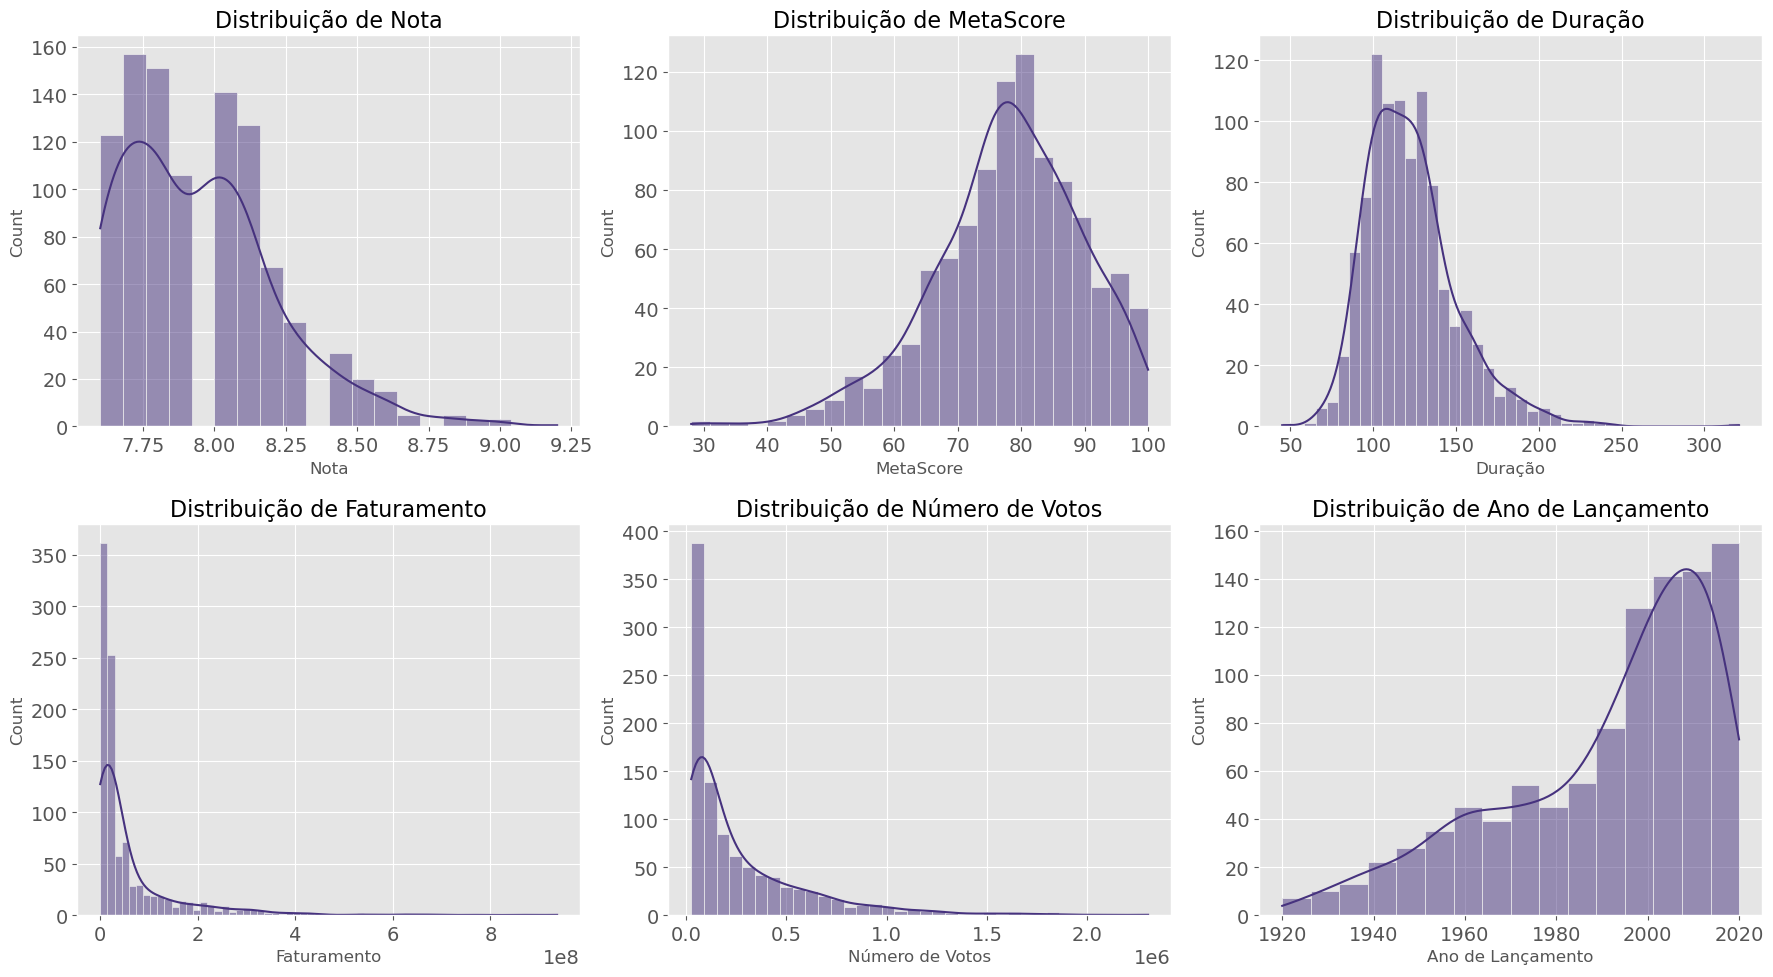

In [10]:
# ---------- Distribuição das variáveis númericas ---------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
variables = ['Nota', 'MetaScore', 'Duração', 'Faturamento', 'Número de Votos', 'Ano de Lançamento']

for i, var in enumerate(variables):
    if var in df.columns:
        row, col = i // 3, i % 3
        sns.histplot(df[var].dropna(), kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'Distribuição de {var}')
        axes[row, col].set_xlabel(var)

plt.tight_layout()
plt.show()


- **Nota:** A maioria dos filmes possui notas entre 7 e 9, apresentando uma predominância de títulos bem avaliados, o que pode indicar que houve uma seleção prévia de títulos de destaque.

- **MetaScore:** A distribuição das notas Meta Score é mais dispersa, mas há concentração entre 60 e 90, mostrando que muitos filmes também são bem avaliados pela crítica especializada.

- **Duração:** A maior parte dos filmes tem duração entre 90 e 180 minutos, refletindo o padrão para longas-metragens.

- **Faturamento:** O faturamento apresenta grande variação, com muitos filmes abaixo de 100 milhões, mas alguns outliers atingem valores muito altos, indicando que poucos títulos concentram grande parte da receita.

- **Número de Votos:** A distribuição é bastante assimétrica, com poucos filmes recebendo muitos votos e a maioria com participação menor do público. Isso reforça a importância de considerar o número de votos como parâmetro de popularidade nas análises.

- **Ano de Lançamento:** O dataset contempla filmes de diversas décadas, com maior concentração a partir dos anos 1990, evidenciando o crescimento da produção cinematográfica recente.

**Conclusão:** O conjunto de dados é composto por filmes majoritariamente bem avaliados, com diversidade de gêneros, faturamento e períodos de lançamento. A análise dessas variáveis é fundamental para entender padrões de sucesso e preferências do público e da crítica.

### 3.1 Análise temporal e tendências

#### 3.1.1 Faturamento por Década

**Objetivo:** Identificar tendências de mercado e crescimento da indústria

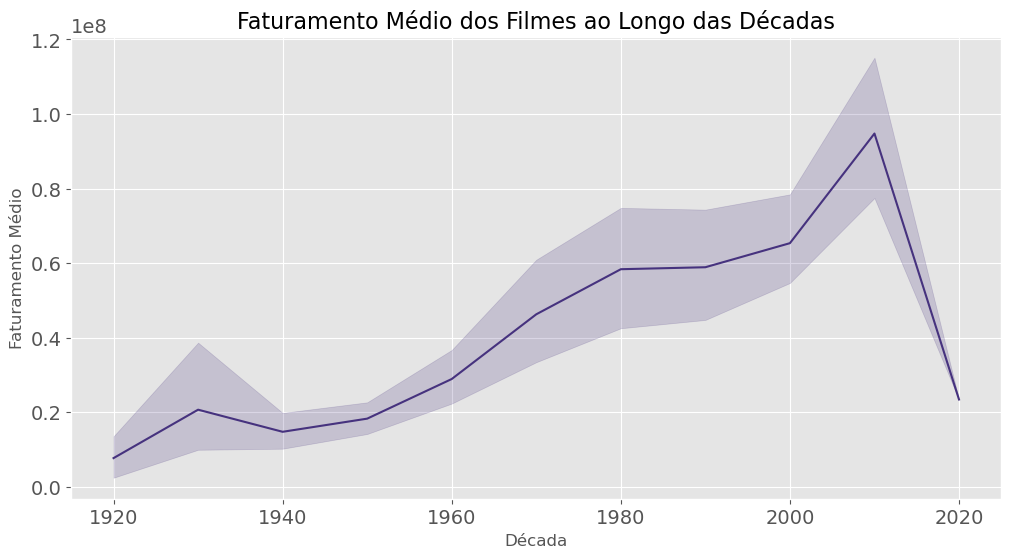

In [11]:
# ---------- Faturamento por década ----------

plot_graph(data=df,
    x='Década',
    y='Faturamento',
    kind='line',
    title='Faturamento Médio dos Filmes ao Longo das Décadas',
    xlabel='Década',
    ylabel='Faturamento Médio'
)


- **Crescimento ao longo do tempo:** Observa-se um aumento consistente do faturamento médio dos filmes nas décadas mais recentes, especialmente a partir dos anos 2000. Isso reflete o crescimento do mercado global, maior investimento em produções e expansão das estratégias de distribuição.

- **Impacto dos blockbusters:** O surgimento de grandes franquias e blockbusters contribuiu para elevar o faturamento médio.

- **Mudanças no consumo:** A popularização do streaming, novas tecnologias e o acesso internacional ampliaram o público e as receitas, principalmente nas décadas mais recentes. 

**Conclusão:** O aumento do faturamento ao longo das décadas pode indicar maior investimento em produções, expansão do mercado consumidor e influência de novas tecnologias. Produções recentes tendem a apresentar maior retorno financeiro, sugerindo oportunidades para inovação e diversificação. Entretanto, é importante destacar que **os valores de faturamento não estão corrigidos pela inflação**.

#### 3.1.2 Número de Votos por Década

**Objetivo**: Identificar o engajamento do público através do número de votos, por período

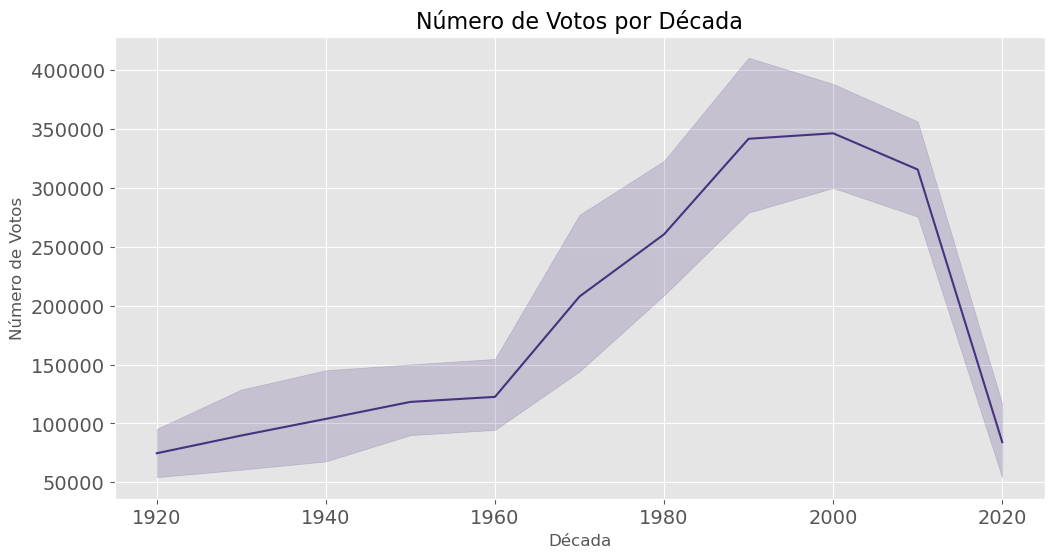

In [12]:
# ---------- Número de votos por década ---------
plot_graph(data=df,
    x='Década',
    y='Número de Votos',
    kind='line',
    title='Número de Votos por Década',
    xlabel='Década',
    ylabel='Número de Votos'
)

- **Crescimento do engajamento:** Observa-se um aumento expressivo no número de votos nas décadas mais recentes, especialmente após os anos 2000. Isso indica maior participação do público na avaliação dos filmes, impulsionada pela popularização da internet e plataformas digitais.

- **Influência das mídias sociais:** O surgimento de redes sociais, sites de avaliação e comunidades online facilitou o compartilhamento de opiniões e ampliou o alcance das produções cinematográficas.

- **Queda entre 2000 e 2010:** Apesar do crescimento geral, há uma queda significativa no número médio de votos ao comparar as décadas de 2000 e 2010. Esse fenômeno pode estar relacionado a mudanças no comportamento do público, fragmentação das plataformas de avaliação, maior diversidade de títulos disponíveis ou até mesmo à ascensão do streaming, que alterou a forma de consumo e engajamento.


**Conclusão:** O aumento do número de votos por década evidencia a evolução do comportamento do público e a importância das plataformas digitais para o engajamento. A queda observada entre 2000 e 2010 sugere que fatores externos, como mudanças tecnológicas e de consumo, podem impactar o engajamento. Para novos projetos, é importante considerar estratégias que ampliem a participação do público e adaptem-se às novas tendências do mercado.

### 3.2 Atores e diretores

#### 3.2.1 Atores por Popularidade (Número de votos)

**Objetivo**: Identificar atores com maior engajamento de público e poder de atração

**Métrica**: Soma acumulada de votos de todos os filmes


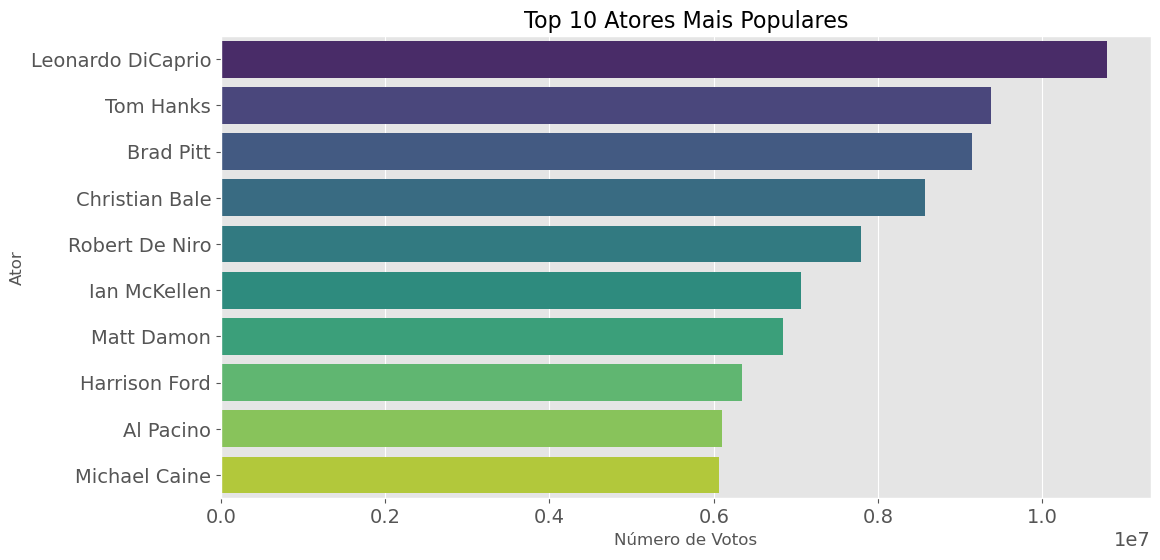

In [13]:
# ---------- Atores por popularidade ---------
atores_long = df.melt(
    id_vars=['Nome do Filme', 'Número de Votos'],
    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
    var_name='Posicao',
    value_name='Ator'
)

ator_popularidade = atores_long.groupby('Ator').agg({
    'Número de Votos':'sum',
    'Nome do Filme':'count'
}).rename(columns={'Nome do Filme':'qtd_filmes'}).reset_index()

top10_populares = ator_popularidade.sort_values('Número de Votos', ascending=False).head(10)

plot_graph(
    data=top10_populares,
    x='Número de Votos',
    y='Ator',
    kind='bar',
    title='Top 10 Atores Mais Populares',
    xlabel='Número de Votos',
    ylabel='Ator'
)


- **Recorrência de grandes estrelas:** Os nomes presentes no ranking, como Leonardo DiCaprio, Brad Pitt, Tom Hanks, Robert De Niro e Christian Bale, são reconhecidos mundialmente e frequentemente associados a grandes produções, franquias de sucesso e filmes premiados.

- **Versatilidade e diversidade de papéis:** Muitos desses atores se destacam por sua capacidade de atuar em diferentes gêneros, do drama à ação, o que amplia seu alcance e engajamento com diferentes públicos.

- **Colaborações frequentes com diretores renomados:** Nomes como Robert De Niro e Leonardo DiCaprio são conhecidos por parcerias recorrentes com diretores de prestígio, potencializando o sucesso dos filmes.

- **Impacto internacional:** Todos os atores do top 10 possuem reconhecimento global, o que reforça a importância de nomes consagrados para o alcance internacional das produções.

**Conclusão:** O ranking dos atores mais populares evidencia que grandes estrelas são fatores decisivos para o engajamento do público. Para novas produções, investir em talentos reconhecidos pode ser um diferencial competitivo para atrair audiência e votos.

#### 3.2.2 Diretores por Popularidade (Número de votos)

**Objetivo**: Identificar diretores com maior alcance e reconhecimento público

**Métrica**: Soma acumulada de votos de todos os filmes


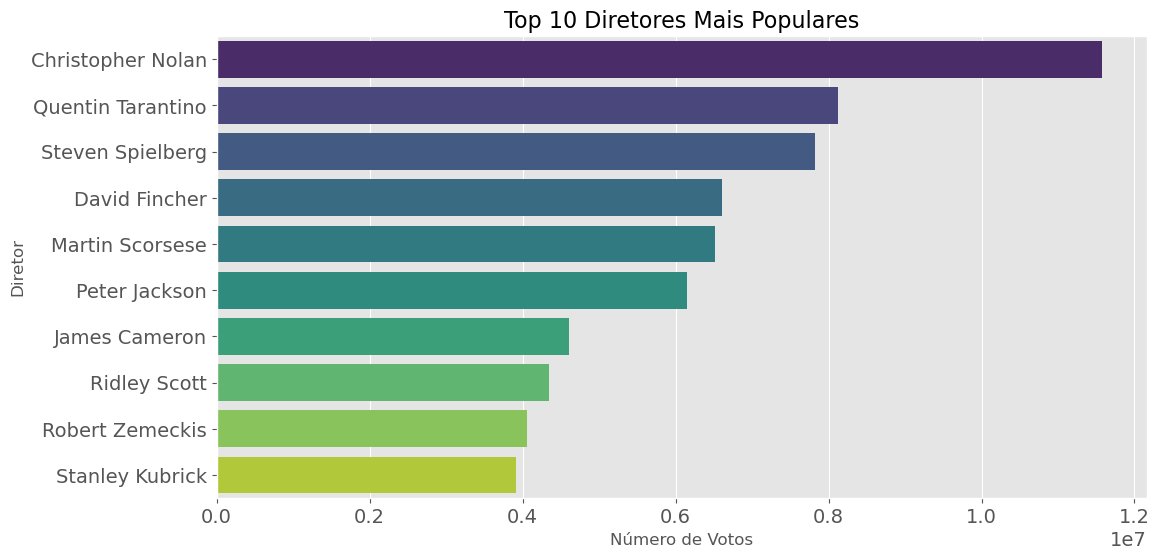

In [14]:
# ---------- Diretores por popularidade ---------
top_diretores = (
    df.groupby("Diretor")["Número de Votos"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

plot_graph(
    data=top_diretores,
    x='Número de Votos',
    y='Diretor',
    kind='bar',
    title='Top 10 Diretores Mais Populares',
    xlabel='Número de Votos',
    ylabel='Diretor'
)


- **Predominância masculina:** Observa-se que poucas mulheres figuram entre os diretores mais populares, evidenciando uma lacuna histórica de representatividade feminina no topo da indústria. Este cenário representa uma grande oportunidade para diversificação e inclusão de novas vozes e perspectivas nas produções cinematográficas.

- **Estabilidade dos mesmos nomes:** Muitos dos diretores presentes no ranking, como Steven Spielberg, Christopher Nolan, Martin Scorsese, Quentin Tarantino e Ridley Scott, mantêm-se entre os mais populares há décadas. Essa estabilidade sugere que o mercado valoriza estilos autorais consolidados e franquias de sucesso, mas também pode indicar barreiras à renovação e à ascensão de novos talentos.

- **Diversidade de estilos e gêneros:** Apesar da estabilidade, o ranking inclui diretores que transitam por diferentes gêneros, do drama ao suspense, ação e ficção científica, ampliando o alcance e engajamento com públicos variados.

- **Franquias e sucessos comerciais:** Muitos desses diretores são responsáveis por franquias de grande sucesso ou filmes que se tornaram referência cultural, como Spielberg com "Jurassic Park" e "Indiana Jones", Nolan com "Batman" e "Inception", e Scott com "Alien" e "Gladiador".

- **Inovação e assinatura autoral:** Diretores como Tarantino e Nolan são conhecidos por estilos únicos e narrativas inovadoras, o que contribui para o alto engajamento e fidelidade do público.

**Conclusão:** O ranking dos diretores mais populares evidencia a força de nomes consolidados e a baixa presença feminina, apontando para a necessidade de maior diversidade e renovação no setor. Para novas produções, investir em talentos diversos e promover oportunidades para diretoras pode ser estratégico para ampliar o alcance e a inovação. Para garantir o sucesso comercial e o alcance de uma nova produção, a presença de diretores populares e consagrados ainda se mostra uma alternativa mais certeira.

#### 3.2.3 Número de Filmes vs. Nota Média para Diretores com mais de 5 filmes dirigidos

**Objetivo:** Identificar diretores consistentemente bons (qualidade sustentada ao longo dos anos)

**Métrica**: Nota média vs quantidade de filmes (consistência)


In [15]:
#----------- Criar dataframe com estatísticas dos diretores -----------
# Agrupar por diretor
diretor_stats = df.groupby('Diretor').agg({
    'Faturamento':'mean',
    'Nome do Filme':'count',
    'Nota':'mean'   # adiciona cálculo da nota média
}).rename(columns={
    'Nome do Filme':'qtd_filmes',
    'Nota':'nota_media'
}).reset_index()

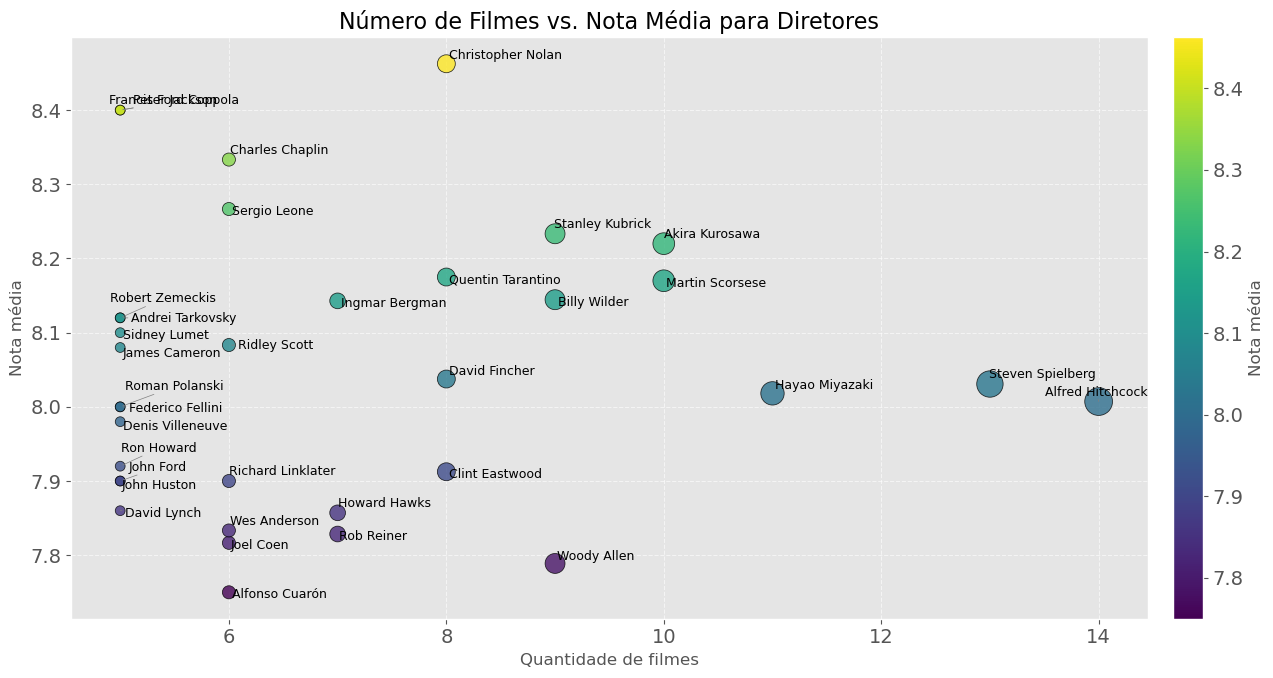

In [16]:
#---------- Número de Filmes vs. Nota para diretores com mais de 5 filmes ----------

# Filtra diretores com mais de 5 filmes
diretor_stats_filtrado = diretor_stats[diretor_stats["qtd_filmes"] >= 5].copy()
fig, ax = plt.subplots(figsize=(14,7))
sc = sns.scatterplot(
    data=diretor_stats_filtrado,
    x="qtd_filmes",
    y="nota_media",
    size="qtd_filmes",
    hue="nota_media",
    sizes=(50, 400),
    palette="viridis",
    alpha=0.8,
    edgecolor="black",
    legend=False
)

# Adiciona os textos em uma lista
texts = []
for _, row in diretor_stats_filtrado.iterrows():
    texts.append(ax.text(row["qtd_filmes"], row["nota_media"], row["Diretor"], fontsize=9))

# Ajusta para não sobrepor
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

# Colorbar
norm = plt.Normalize(diretor_stats_filtrado["nota_media"].min(),
                     diretor_stats_filtrado["nota_media"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Nota média")

ax.set_title("Número de Filmes vs. Nota Média para Diretores")
ax.set_xlabel("Quantidade de filmes")
ax.set_ylabel("Nota média")
ax.grid(linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

- **Consistência de qualidade:** Christopher Nolan aparecem com alta nota média e um bom número de filmes, evidenciando uma trajetória marcada por produções de destaque e reconhecimento crítico.

- **Volume não garante excelência:** Alguns diretores com muitos filmes podem apresentar nota média mais baixa, como Woody Allen e Alfred Hitchcock, indicando que quantidade não necessariamente se traduz em qualidade ou prestígio. Isso sugere que manter altos padrões ao longo de várias produções é um diferencial competitivo.

- **Estilos autorais consolidados:** Nomes como Tarantino e Nolan mantêm notas médias elevadas, reforçando o valor de uma assinatura autoral forte e a fidelidade do público e da crítica.

- **Oportunidade para novos talentos:** A estabilidade dos mesmos nomes no topo reforça a necessidade de renovação e inclusão de novas vozes, especialmente de grupos sub-representados.

**Conclusão:** A relação entre número de filmes e nota média evidencia a consistência e da qualidade autoral de um diretor. Para o setor, valorizar trajetórias sólidas e promover oportunidades para novos talentos pode impulsionar inovação e diversidade nas produções cinematográficas.

#### 3.2.4 Número de Filmes vs. Faturamento Médio para Diretores com mais de 5 filmes

**Objetivo**: Identificar diretores comercialmente consistentes

**Métrica**: Faturamento médio por filme vs volume de trabalho

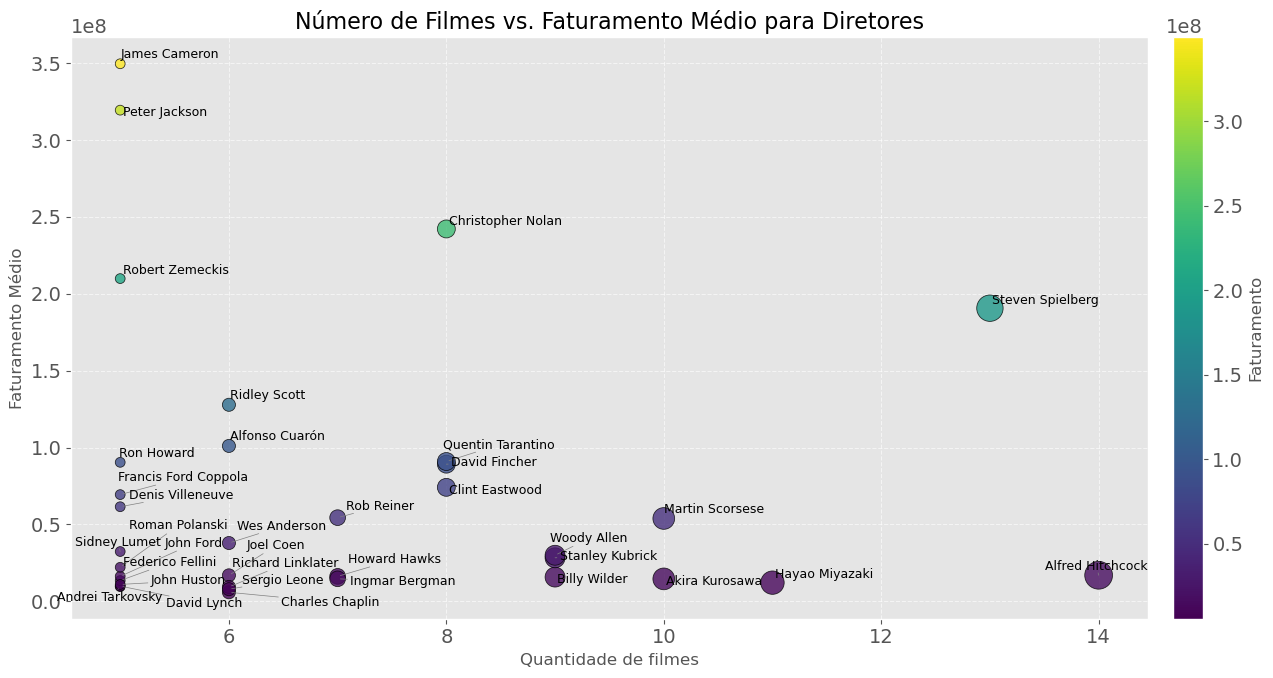

In [17]:
# ---------- Número de filmes vs. Faturamento médio para diretores com mais de 5 filmes ----------
# Filtra diretores com mais de 5 filmes
diretor_stats_filtrado = diretor_stats[diretor_stats["qtd_filmes"] >= 5].copy()
fig, ax = plt.subplots(figsize=(14,7))
sc = sns.scatterplot(
    data=diretor_stats_filtrado,
    x="qtd_filmes",
    y="Faturamento",
    size="qtd_filmes",
    hue="Faturamento",
    sizes=(50, 400),
    palette="viridis",
    alpha=0.8,
    edgecolor="black",
    legend=False
)

# Adiciona os textos em uma lista
texts = []
for _, row in diretor_stats_filtrado.iterrows():
    texts.append(ax.text(row["qtd_filmes"], row["Faturamento"], row["Diretor"], fontsize=9))

# Ajusta para não sobrepor
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

# Colorbar
norm = plt.Normalize(diretor_stats_filtrado["Faturamento"].min(),
                     diretor_stats_filtrado["Faturamento"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Faturamento")

ax.set_title("Número de Filmes vs. Faturamento Médio para Diretores")
ax.set_xlabel("Quantidade de filmes")
ax.set_ylabel("Faturamento Médio")
ax.grid(linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

- **Domínio dos blockbusters:** James Cameron e Peter Jackson lideram o ranking de faturamento médio, ultrapassando a marca de 300 milhões de dólares por filme.

- **Equilíbrio entre volume e retorno:** Christopher Nolan e Steven Spielberg aparecem em destaque conciliando grande número de filmes com faturamentos médios expressivos.

- **Consagração e diversidade de estilos:** Ridley Scott, Robert Zemeckis e Alfonso Cuarón mostram que diferentes estilos cinematográficos também alcançam faturamentos relevantes.

- **Clássicos versus contemporâneos:** Alfred Hitchcock, Billy Wilder e Akira Kurosawa têm faturamentos médios mais modestos (ajustados pela época), mas reafirmam relevância histórica e legado artístico.  

**Conclusão:** O faturamento médio elevado está concentrado em diretores de blockbusters contemporâneos, enquanto os clássicos se destacam mais pelo impacto cultural.

#### 3.2.5 Número de Filmes vs. Nota Média para Atores com mais de 5 Filmes

**Objetivo**: Identificar atores consistentemente bons (qualidade sustentada)

**Métrica**: Nota média vs quantidade de filmes (consistência)


In [18]:
# --------- Criar df para estatísticas específicas de atores ----------
df_temp = df[['Nome do Filme', 'Nota', 'Faturamento', 'Star1', 'Star2', 'Star3', 'Star4']].copy()

# Transformar atores em formato longo (cada ator em uma linha)
atores_long = df_temp.melt(
    id_vars=['Nome do Filme', 'Nota', 'Faturamento'],
    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
    var_name='Posicao',
    value_name='Ator'
)

# Agrupar por ator
ator_stats = atores_long.groupby('Ator').agg({
    'Nota':'mean',           # média das notas dos filmes do ator
    'Faturamento':'mean',    # média do faturamento dos filmes do ator
    'Nome do Filme':'count'  # quantidade de filmes
}).rename(columns={'Nome do Filme':'qtd_filmes'}).reset_index()

# Filtrar apenas atores com pelo menos 5 filmes
ator_stats = ator_stats[ator_stats['qtd_filmes'] >= 5]


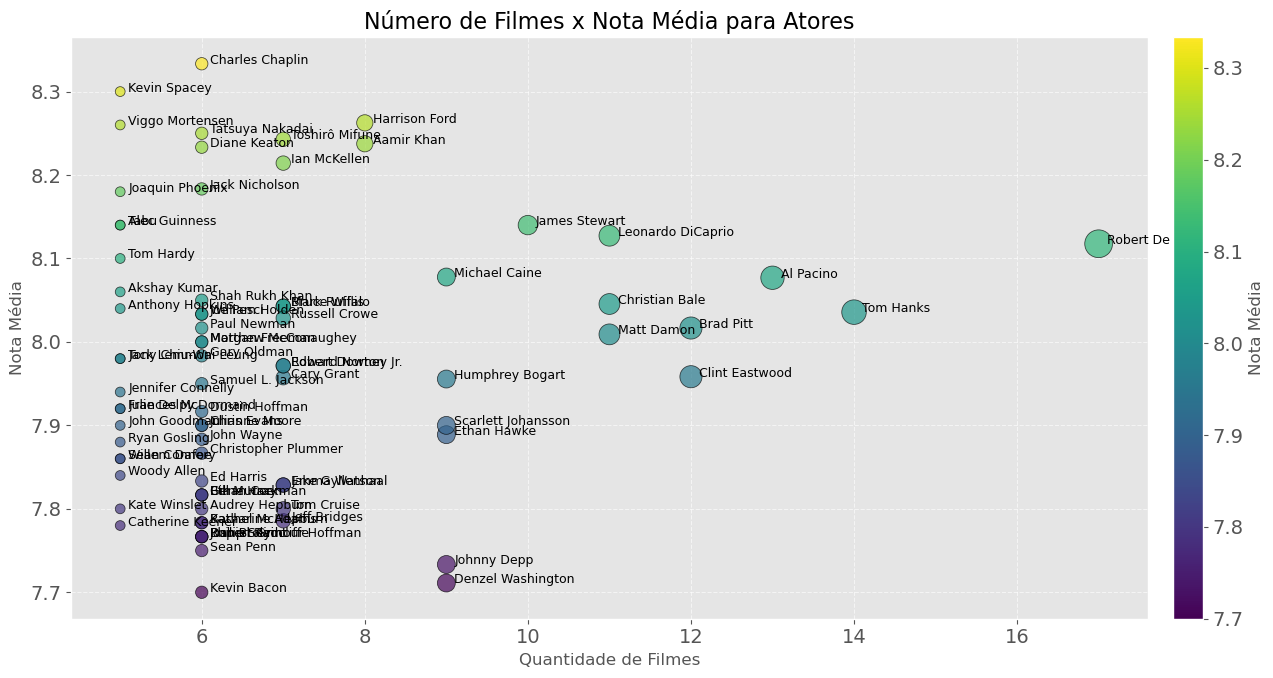

In [19]:
# ---------- Número de Filmes x Nota Média para atores com mais de 5 filmes ----------

# Scatter plot
plt.figure(figsize=(14,7))
ax = plt.gca()  # pegar o eixo atual
sc = sns.scatterplot(
    data=ator_stats,
    x='qtd_filmes',
    y='Nota',
    size='qtd_filmes',
    hue='Nota',
    palette='viridis',
    sizes=(50, 400),
    alpha=0.7,
    edgecolor='black'
)

# Adicionar nomes dos atores
for i, row in ator_stats.iterrows():
    plt.text(row['qtd_filmes']+0.1, row['Nota'], row['Ator'], fontsize=9)

# ---------- Inserir colorbar ----------
norm = plt.Normalize(ator_stats['Nota'].min(), ator_stats['Nota'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Nota Média")

plt.title('Número de Filmes x Nota Média para Atores')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Nota Média')
plt.grid(linestyle='--', alpha=0.6)
plt.legend([],[], frameon=False)  # remove legenda
plt.tight_layout()
plt.show()


- **Consistência de performance:** Atores como Kevin Spacey, Harrison Ford e Viggo Mortensen apresentam alta nota média mantendo um número consistente de filmes, indicando capacidade de entregar qualidade recorrente em suas obras. Destaque para Charles Chaplin, que apresenta a maior nota média em relação ao número de filmes, para um ator, destacando a relevância cultural de sua obra.

- **Equilíbrio entre quantidade e qualidade:** Muitos atores do topo, como Diane Keaton, Harrison Ford e Aamir Khan, combinam volume de produções com excelente desempenho crítico, sugerindo que uma carreira bem-sucedida não depende apenas da frequência, mas também da escolha estratégica de papéis.

- **Potencial de impacto em novas produções:** A presença de atores com alta nota média em várias obras oferece um indicador confiável para selecionar elenco em novos projetos que busquem reconhecimento crítico e sucesso junto ao público.

**Conclusão:** A lista dos atores com mais de 5 filmes e maior nota média evidencia que a escolha de elenco experiente e consistentemente bem avaliado pode influenciar positivamente a recepção de uma nova produção, equilibrando prestígio e retorno crítico.


#### 3.2.6 Número de Filmes vs. Faturamento Médio para Atores com mais de 5 filmes


**Objetivo**: Identificar atores comercialmente consistentes

**Métrica**: Faturamento médio por filme vs volume de trabalho

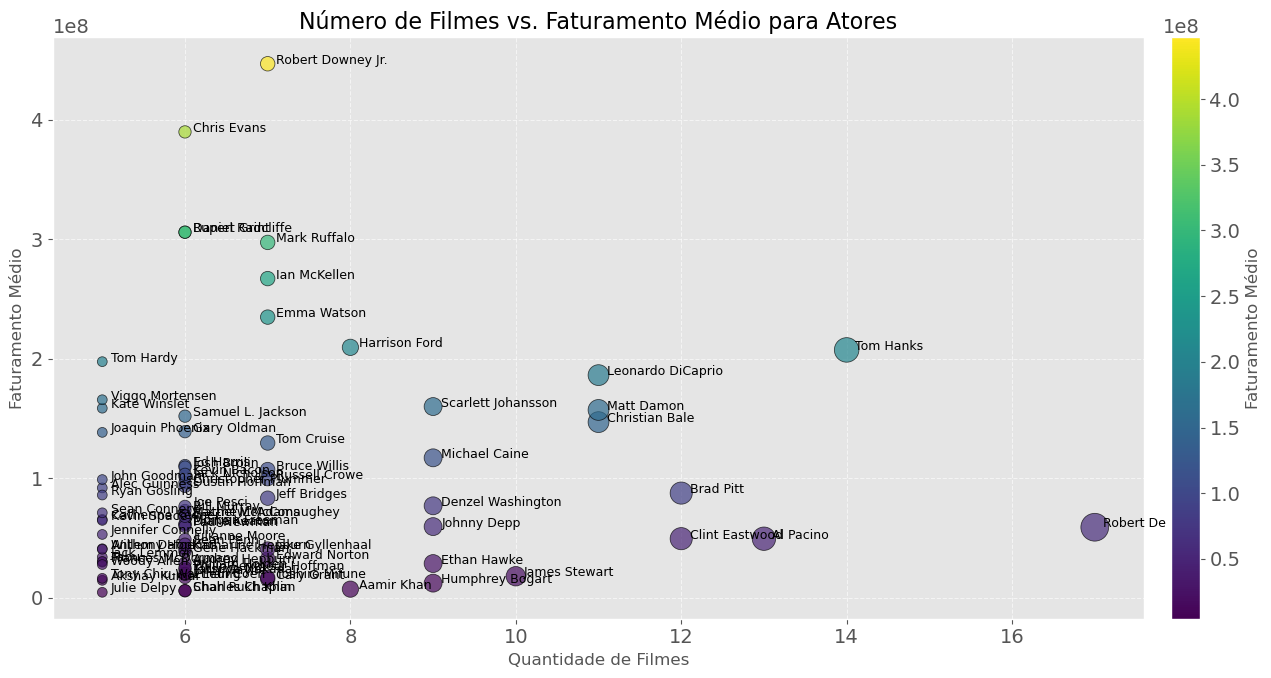

In [20]:
# ---------- Númeor de Filmes vs. Faturamento Médio para atores com mais de 5 filmes ----------
plt.figure(figsize=(14,7))
ax = plt.gca()

# Scatter plot
sc = sns.scatterplot(
    data=ator_stats,
    x='qtd_filmes',
    y='Faturamento',
    size='qtd_filmes',
    hue='Faturamento',
    palette='viridis',
    sizes=(50, 400),
    alpha=0.7,
    edgecolor='black',
    legend=False
)

# Adicionar nomes dos atores
texts = []
for i, row in ator_stats.iterrows():
    texts.append(ax.text(row['qtd_filmes']+0.1, row['Faturamento'], row['Ator'], fontsize=9))

# Colorbar
norm = plt.Normalize(ator_stats['Faturamento'].min(), ator_stats['Faturamento'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Faturamento Médio")

plt.title('Número de Filmes vs. Faturamento Médio para Atores')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Faturamento Médio')
plt.grid(linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- **Retorno financeiro concentrado:** Atores como Robert Downey Jr., Chris Evans e Daniel Radcliffe apresentam o maior faturamento médio por filme, evidenciando que determinados nomes conseguem atrair grandes audiências e receitas mesmo com um número relativamente pequeno de produções.

- **Consistência vs. blockbuster:** Alguns atores com maior número de filmes, como Harrison Ford e Tom Hanks, combinam um portfólio volumoso com faturamentos médios relevantes, sugerindo que a consistência de aparições em filmes de sucesso também gera retorno financeiro significativo.

- **Atores de nicho e impacto:** Ian McKellen, Emma Watson e Mark Ruffalo mostram que mesmo atores em franquias ou papéis específicos podem manter faturamentos médios altos, reforçando a importância de escolhas estratégicas de projeto para maximizar retorno.

**Implicação:** Para uma nova produção, investir em atores que já demonstraram alto faturamento médio pode aumentar a probabilidade de sucesso comercial imediato. A estratégia ideal combina nomes de grande apelo de público e atores consistentes com histórico comprovado de receita.

### 3.3 Análise de Gênero

#### 3.3.1 Frequência de Gêneros

**Objetivo:** Avaliar a distribuição de filmes por gênero e identificar segmentos dominantes

**Métrica:** Contagem de filmes por gênero

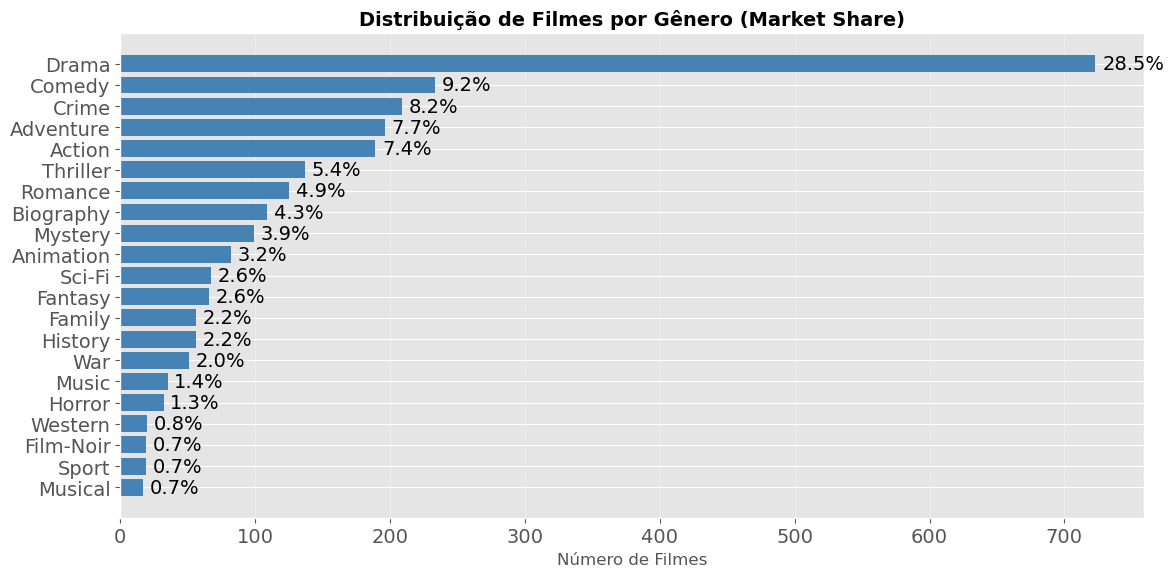

In [21]:
# ---------- Frequência de cada gênero por filmes ----------
# Soma os 1's de cada coluna de gênero
frequencia_generos = generos_dummies.sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
bars = plt.barh(frequencia_generos.index, frequencia_generos.values, color='steelblue')
plt.xlabel('Número de Filmes')
plt.title('Distribuição de Filmes por Gênero (Market Share)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Maior no topo

# Adicionar porcentagens
total = frequencia_generos.sum()
for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = (width / total) * 100
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, 
             f'{percentage:.1f}%', ha='left', va='center')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

- **Predominância de gêneros clássicos:** Drama, Comédia e Crime aparecem como os gêneros mais frequentes, indicando que narrativas humanas profundas, humor e histórias de investigação são amplamente valorizadas e produzidas.

- **Gêneros de nicho e menor frequência:** Gêneros como Musical, Esporte, Western e Noir apresentam menor representatividade, sugerindo que são voltados para públicos específicos ou menos explorados comercialmente.

**Conclusão:** A concentração em gêneros populares se mostra uma decisão adequada para estratégias de produção para maximizar audiência e retorno financeiro. Ao mesmo tempo, investir em gêneros de menor frequência oferece oportunidade de inovação, diferenciação de portfólio e conquista de novos segmentos de público ou exploração de um mercado específico.

#### 3.3.2 Nota Média vs Faturamento Médio por Gênero

**Objetivo:** Identificar gêneros que combinam qualidade crítica e sucesso financeiro

**Métrica:** Média de nota IMDB vs média de faturamento por gênero

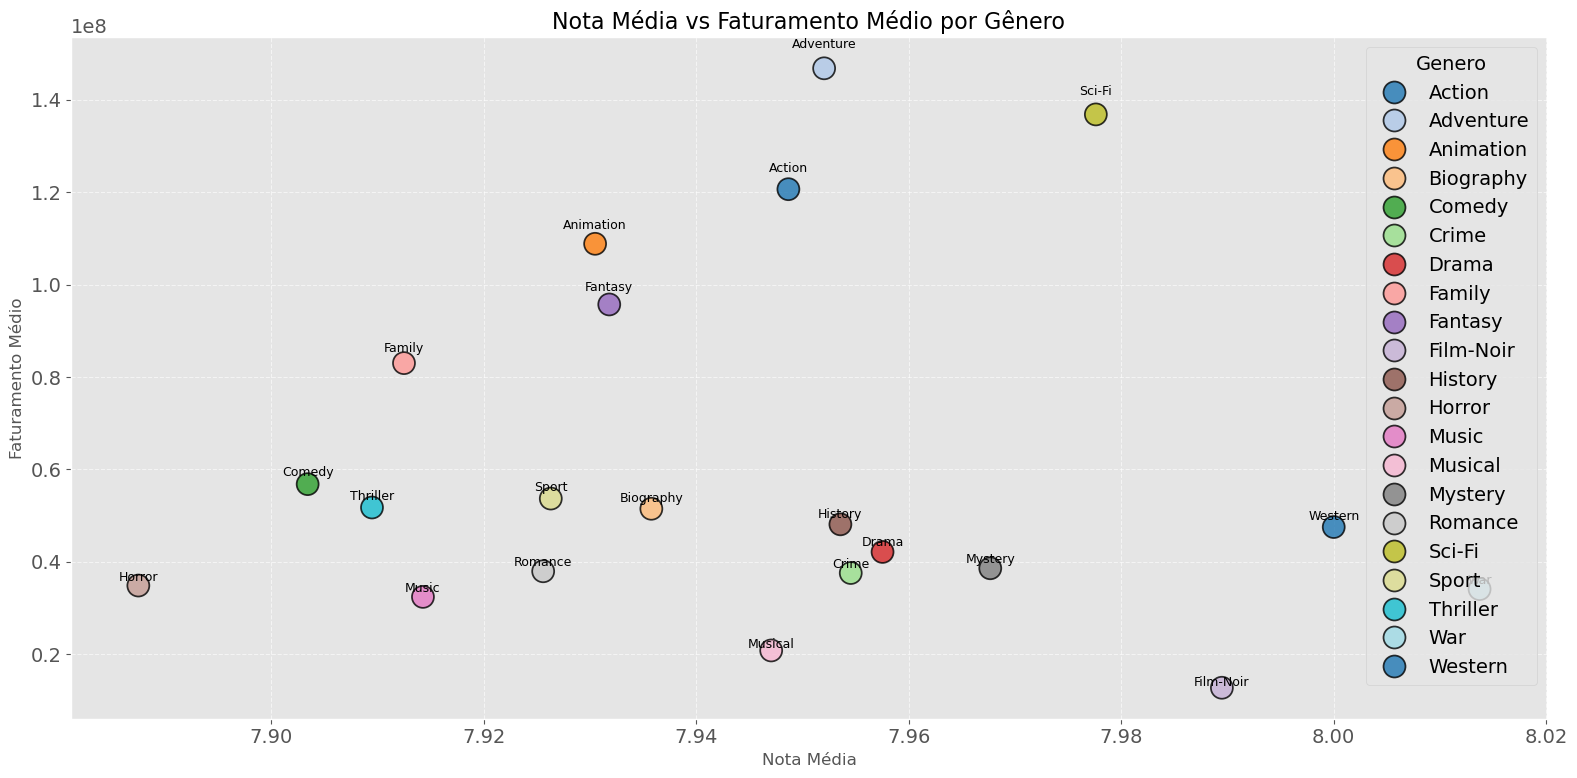

In [22]:
# ---------- Nota Média vs Faturamento Médio por Gênero ----------
# Cria dataframe temporário para métricas
metrics_temp = pd.DataFrame([{
    'Genero': col,
    'Nota_Média': df.loc[df[col]==1, 'Nota'].mean(),
    'Faturamento_Médio': df.loc[df[col]==1, 'Faturamento'].mean(),
    'Qtd_Filmes': df[col].sum()
} for col in generos_dummies])

# Plot
plt.figure(figsize=(16,8))
scatter = sns.scatterplot(
    x='Nota_Média',
    y='Faturamento_Médio',
    hue='Genero',
    palette='tab20',
    data=metrics_temp,
    s=250,
    alpha=0.8,
    edgecolor='black',
    legend=True
)

# Adiciona nomes dos gêneros sobre os pontos
for i, row in metrics_temp.iterrows():
    plt.text(
        row['Nota_Média'],
        row['Faturamento_Médio']*1.03,
        row['Genero'],
        fontsize=9,
        ha='center'
    )

plt.title('Nota Média vs Faturamento Médio por Gênero', fontsize=16)
plt.xlabel('Nota Média', fontsize=12)
plt.ylabel('Faturamento Médio', fontsize=12)
plt.grid(linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Distribuição dos dados**: Não há correlação clara e linear entre nota média e faturamento médio, o que indica que filmes com nota alta nem sempre faturam mais.

**Gêneros com notas médias e faturamento alto:** Filmes de Aventura, Ficção Científica, Ação e Animação apresentam notas medianas, entre 7.93 e 7.98, com faturamento superior a 100 milhões. Isso indica que estes gêneros atraem o público mesmo sem avaliação crítica excepcional, os destacando como campeões de bilheteria.

**Gêneros com notas médias e faturamento médio:**  Filmes voltados para a família e de Fantasia, apresentam notas menores em relação aos gêneros de maior faturamento, porém, ainda apresentam faturamentos acima da média (entre 80 e 100 milhões), sugerindo que são capazes de atrair o público e gerar receita.

**Gêneros com altas notas e faturamento baixo:** Filmes Noir, sobre Guerra e Western têm notas próximas a 8, mas faturamento médio abaixo de 50 milhões. Isso indica que gêneros de nicho ou clássicos são bem avaliados mas não geram grandes receitas.

**Gêneros com notas médias e faturamento baixo:** Musical, Crime, Horror e filmes sobre Música apresentam notas medianas e baixo faturamento (abaixo de 40 milhões), indicando que estes filmes são voltados para públicos específicos.


**Conclusão:** Alguns gêneros combinam alto retorno financeiro com risco de nota menor, enquanto outros oferecem estabilidade crítica com faturamento moderado.

### 3.3.3 Distribuição de Notas por Gênero

**Objetivo:** Avaliar a variabilidade de qualidade dentro de cada gênero

**Métrica:** Distribuição das notas IMDB por gênero

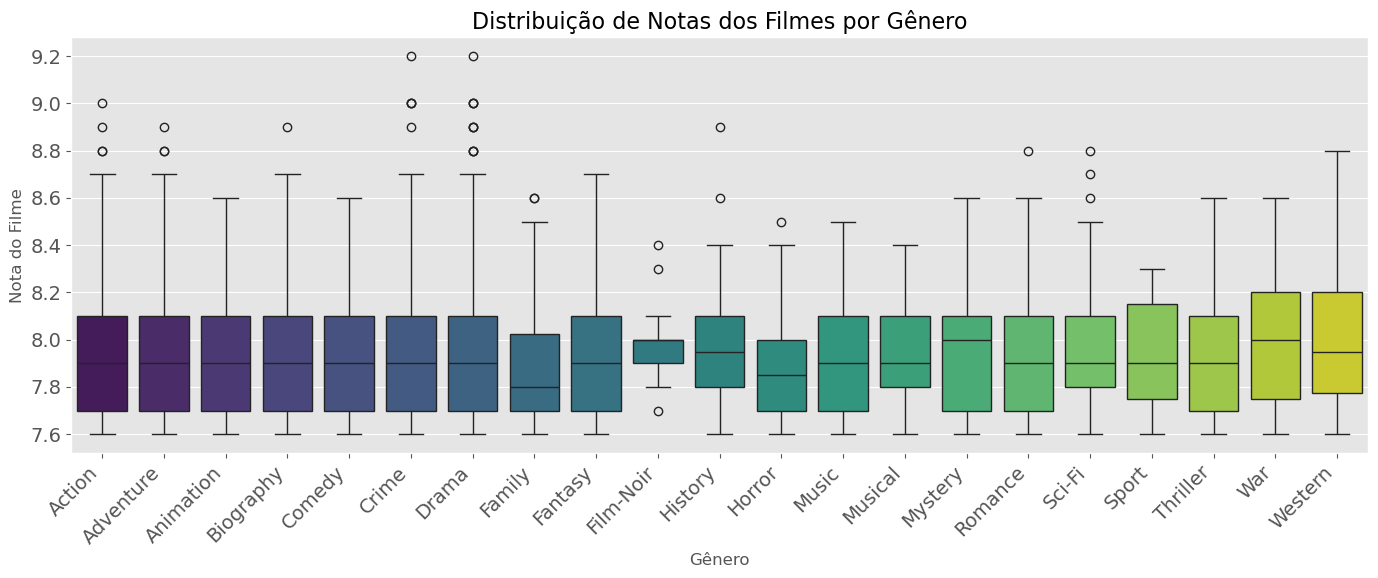

In [23]:
# ---------- Boxplot de notas por gênero ----------
# Cria dataframe “long” para plot
generos_long = generos_dummies.copy()
generos_long['Nota'] = df['Nota']

# Explodir cada gênero em uma linha para o mesmo filme
generos_melted = generos_long.melt(id_vars='Nota', var_name='Gênero', value_name='Presença')
generos_melted = generos_melted[generos_melted['Presença'] == 1]  # considerar só quando o filme tem o gênero

# Plot
plt.figure(figsize=(14,6))
sns.boxplot(x='Gênero', y='Nota', data=generos_melted, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Notas dos Filmes por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Nota do Filme')
plt.tight_layout()
plt.show()

- **Notas:** A mediana da maioria dos gêneros está entre 7,8 e 8,0, indicando avaliações consistentes e positivas. Filme Noir se destaca com medianas ligeiramente mais altas (~8,0).

- **Dispersão e variação:** Ação, Crime, Drama e Aventura apresentam maior variação nas notas.

- **Outliers:** Alguns filmes de Crime, Drama e Ação alcançam notas muito altas (>9,0), mostrando títulos excepcionais que fogem do padrão.

- **Simetria e tendências:** A maioria dos gêneros tem distribuição simétrica; Film-Noir e Históricos apresentam leve enviesamento para notas altas.

**Conclusão:** A maioria dos gêneros mantém notas consistentes entre 7,8 e 8,0, com Film-Noir ligeiramente mais alto. Ação, Crime, Drama e Aventura apresentam maior variação, incluindo outliers excepcionais (>9,0).
As distribuições são majoritariamente simétricas, com leve enviesamento positivo para filmes Noir e filmes históricos.



#### 3.3.4 Retorno financeiro médio e risco

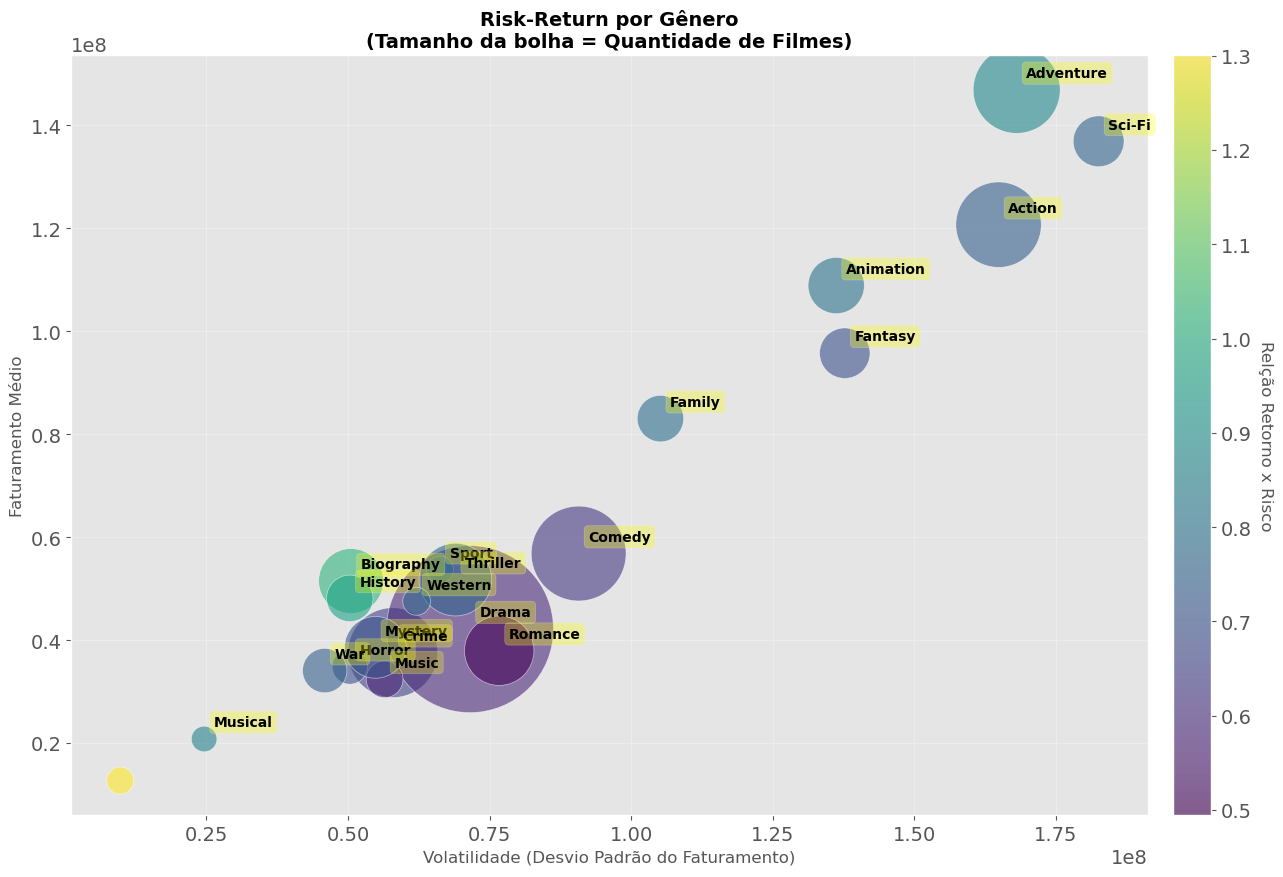

In [24]:
# ---------- Risk-Return por Gênero (Faturamento Médio vs Volatilidade) ----------
# Calcular métricas por gênero usando dummies
df_risk_return = df.copy()
generos_dummies_cols = generos_dummies.columns.tolist()
generos_risk = df_risk_return[generos_dummies_cols + ['Faturamento']]

# Calcular métricas por gênero
metrics = []
for genero in generos_risk.columns[:-1]:
    subset = generos_risk[generos_risk[genero] == 1]
    faturamento_medio = subset['Faturamento'].mean()
    volatilidade = subset['Faturamento'].std()
    qtd_filmes = subset.shape[0]
    metrics.append([genero, faturamento_medio, volatilidade, qtd_filmes])

genre_risk_return = pd.DataFrame(metrics, columns=['Gênero', 'Faturamento_Medio', 'Volatilidade', 'Qtd_Filmes'])
genre_risk_return = genre_risk_return.dropna()

# Bubble chart
plt.figure(figsize=(14, 9))
relacao = genre_risk_return['Faturamento_Medio'] / genre_risk_return['Volatilidade'].replace(0, np.nan)
scatter = plt.scatter(
    x=genre_risk_return['Volatilidade'],
    y=genre_risk_return['Faturamento_Medio'],
    s=genre_risk_return['Qtd_Filmes']*20,
    alpha=0.6,
    c=relacao,
    cmap='viridis',
    edgecolors='w',
    linewidth=0.5
)

# Anotações para os 10 gêneros com maior faturamento médio
for genero in genre_risk_return.nlargest(20, 'Faturamento_Medio')['Gênero']:
    plt.annotate(
        genero,
        (genre_risk_return.loc[genre_risk_return['Gênero'] == genero, 'Volatilidade'].values[0],
         genre_risk_return.loc[genre_risk_return['Gênero'] == genero, 'Faturamento_Medio'].values[0]),
        xytext=(7, 7),
        textcoords='offset points',
        ha='left',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3)
    )

# Colorbar
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Relção Retorno x Risco', rotation=270, labelpad=15)

# Labels e título
plt.xlabel('Volatilidade (Desvio Padrão do Faturamento)', fontsize=12)
plt.ylabel('Faturamento Médio', fontsize=12)
plt.title('Risk-Return por Gênero\n(Tamanho da bolha = Quantidade de Filmes)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- **Gêneros de blockbuster:** Aventura, Ação e Sci-Fi aparecem no canto superior direito, indicando alto faturamento médio e alta volatilidade. Estes gêneros possuem muitas produções, refletido pelo tamanho das bolhas. Pela cor da bolha do gênero Aventura, o risco de retorno é relativamente baixo, comparado aos gêneros Ação e Ficção Científica.

- **Eficiência (Retorno/Risco):** Filmes biográficos e históricos, localizados no canto inferior esquerdo, apresentam cores mais claras, mostrando bom retorno relativo ao risco, sugerindo eficiência na relação retorno x volatilidade.

- **Trade-off clássico risco x retorno:** Existe uma tendência clara de que, quanto maior o faturamento médio, maior a volatilidade. Poucos gêneros combinam alto retorno com baixo risco.

**Conclusão:** Aventura, Ação e Sci-Fi lideram em faturamento e volatilidade, com Aventura apresentando menor risco relativo. Filmes biográficos e históricos mostram bom retorno frente ao risco. É possível observar que o maior faturamento médio tende a acompanhar maior volatilidade, e poucos gêneros equilibram retorno e risco.


#### 3.4 Avaliação de Popularidade

#### 3.4.1 Filmes com melhores notas, mais votos e maior faturamento

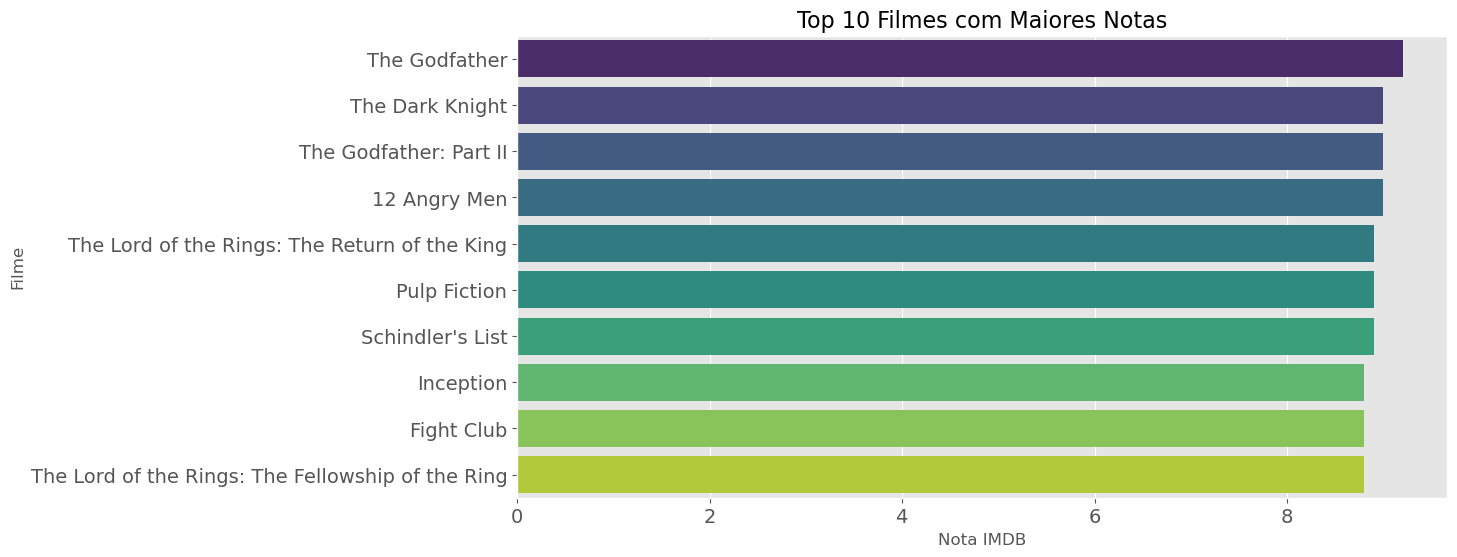

In [25]:
# ---------- 10 filmes com maiores notas ----------
top10_notas = df.nlargest(10, 'Nota')[['Nome do Filme', 'Nota']]

plot_graph(
    data=top10_notas,
    x='Nota',
    y='Nome do Filme',
    kind='bar',
    title='Top 10 Filmes com Maiores Notas',
    xlabel='Nota IMDB',
    ylabel='Filme'
)

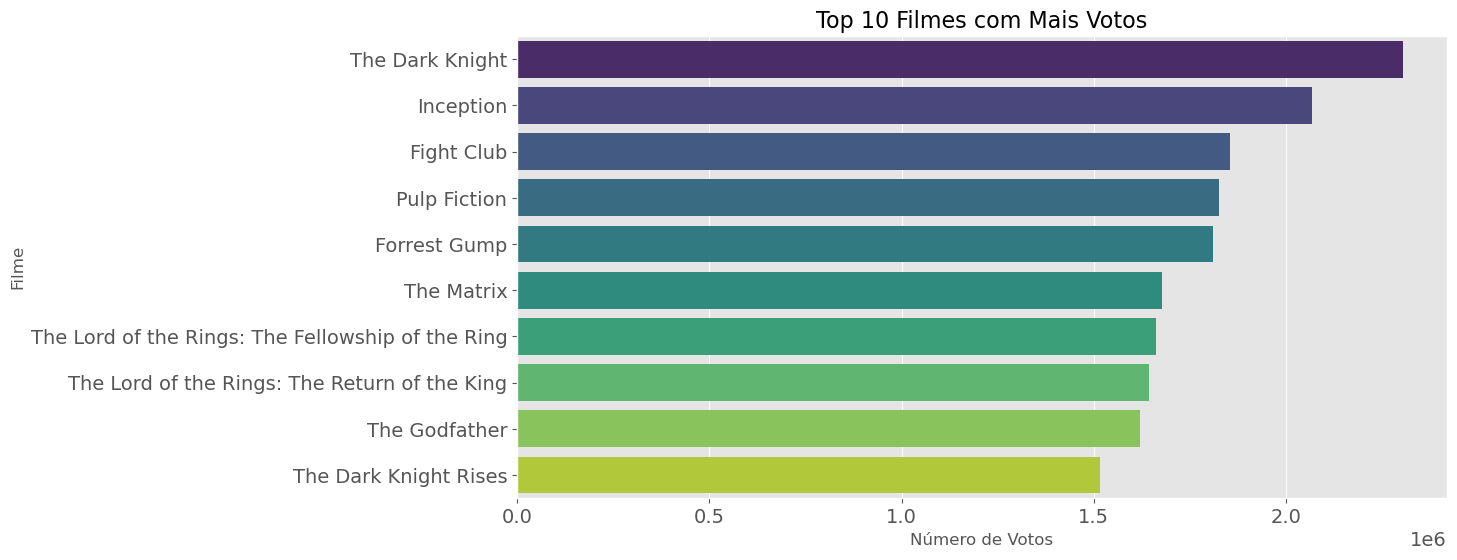

In [26]:
# ---------- 10 filmes com mais votos ----------
top_10_votos = df.nlargest(10, 'Número de Votos')[['Nome do Filme', 'Número de Votos']]

plot_graph(
    data=top_10_votos,
    x='Número de Votos',
    y='Nome do Filme',
    kind='bar',
    title='Top 10 Filmes com Mais Votos',
    xlabel='Número de Votos',
    ylabel='Filme'
)


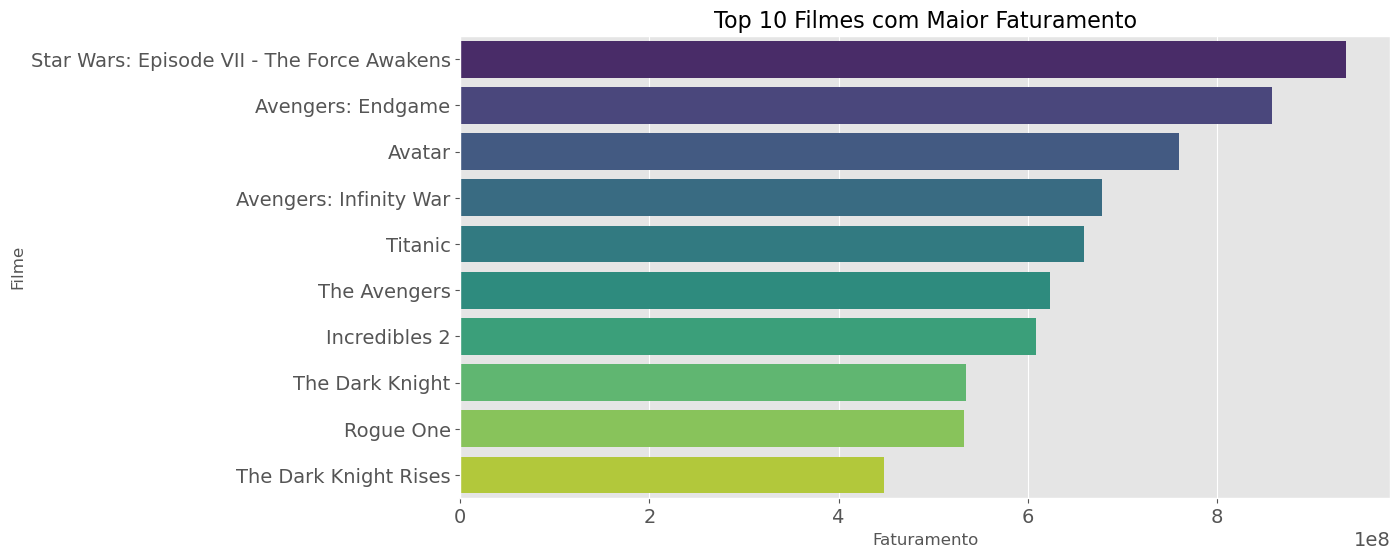

In [27]:
# ---------- Filmes com maior Faturamento ----------
top_10_faturamento = df.nlargest(10, 'Faturamento')[['Nome do Filme', 'Faturamento']]

plot_graph(
    data=top_10_faturamento,
    x='Faturamento',
    y='Nome do Filme',
    kind='bar',
    title='Top 10 Filmes com Maior Faturamento',
    xlabel='Faturamento',
    ylabel='Filme'
)


- **Top 10 Filmes com Maiores Notas:** Os filmes que lideram o ranking de notas são filmes clássicos que possuem grande aprovação crítica e do público especializado. No entanto, nem sempre esses filmes são os mais populares em termos de audiência.

- **Top 10 Filmes com Mais Votos:** Os filmes com maior número de votos são filmes amplamente assistidos, discutidos e recomendados, podendo incluir grandes franquias, blockbusters ou produções recentes que geraram engajamento massivo.

- **Top 10 Filmes com Maiores Faturamentos:** Os filmes com maiores faturamentos são filmes amplamente aprovados pelo público e que, não necessariamente, apresentam as melhores notas e mais votos nas plataformas, evidenciando que o faturamento pode ser um grande indicativo de popularidade.

**Conclusão:** Os filmes com maiores faturamentos são, sabidamente, filmes que possuem grande aprovação popular, como a franquia Star Wars, Avengers e Avatar. Isso mostra que o faturamento pode ser um bom indicativo de popularidade, apesar destes filmes não apresentam as melhores notas nem o maior número de votos em plataformas. É possível inferir também, que nem sempre a relação dos filmes com sua popularidade está atrelada ao número de votos  ou a nota da crítica em geral.

#### 3.4.2 Filmes mais populares usando Weighted Rating

Para identificar os filmes que são simultaneamente bem avaliados e populares, utilizei o **Weighted Rating (WR)**, uma métrica ponderada que combina a nota do filme com o número de votos recebidos. Essa abordagem evita que filmes com poucas avaliações, mesmo que altas, apareçam no topo da lista, priorizando títulos que têm consenso positivo em um público significativo.

A fórmula utilizada é:

\
WR=(v/v+m​)⋅R+(m/v+m​)⋅C


Onde:

- \(R\) = Nota do filme (IMDB Rating)  
- \(v\) = Número de votos do filme  
- \(m\) = Mínimo de votos exigido para estar na lista (definido aqui como o 90º percentil do número de votos)  
- \(C\) = Média das notas de todos os filmes  

No gráfico apresentado, observamos os **10 filmes com maior WR**, destacando títulos que não apenas possuem alta avaliação, mas também uma base significativa de votos, refletindo popularidade e qualidade reconhecida pelo público. Cada barra representa o WR do filme, permitindo uma comparação direta entre os títulos.

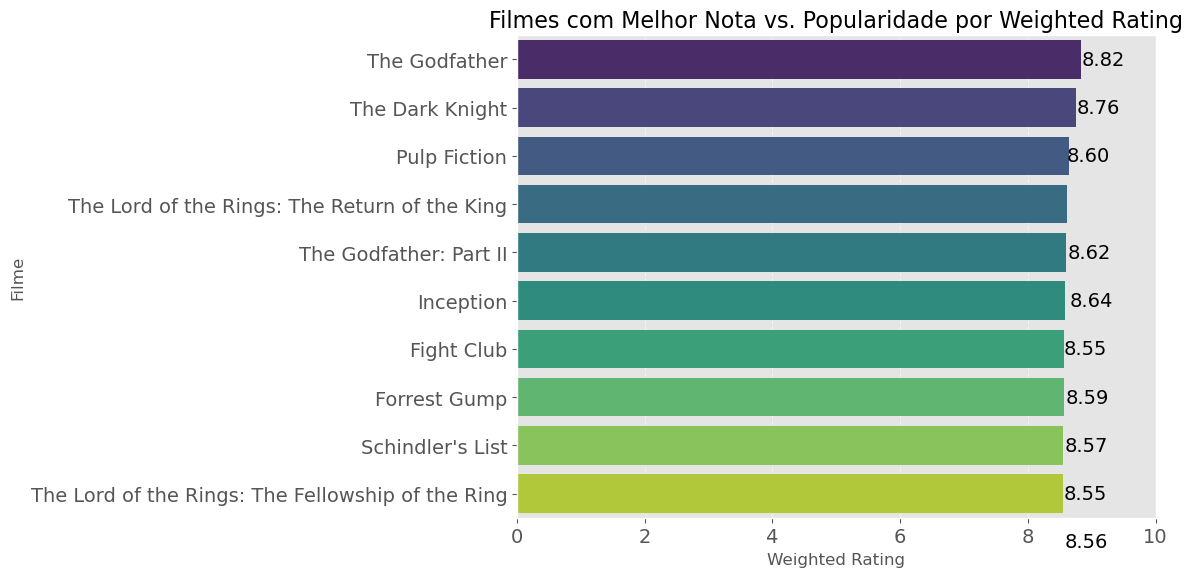

In [28]:
#---------- Top 10 filmes com melhor nota x popularidade (Weighted Rating) ----------
# Parâmetros
C = df['Nota'].mean()           # média das notas
m = df['Número de Votos'].quantile(0.90)  # mínimo de votos para entrar (top 10% de votos)

# Filtrar apenas filmes com votos >= m
df_filtrado = df[df['Número de Votos'] >= m].copy()

# Weighted rating
df_filtrado['WR'] = (df_filtrado['Número de Votos']/(df_filtrado['Número de Votos'] + m) * df_filtrado['Nota']) + (m/(df_filtrado['Número de Votos'] + m) * C)

# Top 10 filmes
top10_wr = df_filtrado.nlargest(10, 'WR')[['Nome do Filme', 'Nota', 'Número de Votos', 'WR']]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    x='WR', 
    y='Nome do Filme', 
    data=top10_wr, 
    palette='viridis',
    orient='h'
)
# Adicionar a nota WR dentro da barra
for i, row in top10_wr.iterrows():
    plt.text(
        row['WR'] + 0.01,
        i, 
        f"{row['WR']:.2f}", 
        va='center'
    )
plt.title('Filmes com Melhor Nota vs. Popularidade por Weighted Rating')
plt.xlabel('Weighted Rating')
plt.ylabel('Filme')
plt.xlim(0, 10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- **Diferenças entre qualidade e popularidade:** Os filmes com as melhores notas nem sempre são os mais votados. Muitas vezes, títulos cultuados pela crítica ou com apelo artístico elevado recebem menos votos, enquanto blockbusters e franquias populares acumulam grandes quantidades de votos, mesmo sem notas máximas, como 12 Angry Man e Schindler's List.

- **Weighted Rating (WR) como equilíbrio:** O WR destaca filmes que conseguem unir alta avaliação e grande participação do público. Títulos que aparecem no topo do WR são aqueles que conquistaram consenso tanto em qualidade quanto em popularidade, tornando-se referências para recomendações. Pode-se notar a presença de The Godfather (O Poderoso Chefão) e Batman: The Dark Night, presentes nas primeiras posições das listas que destacam quantidade de votos, melhores notas e notas por número de votos, destacando que são filmes consagrados tanto pela crítica, quanto pelo público.

- **Valor estratégico do WR:** Utilizar WR como métrica permite identificar filmes que não apenas agradam a poucos, mas que são amplamente reconhecidos e apreciados, evitando distorções causadas por baixa quantidade de votos ou popularidade sem excelência.

**Conclusão:** A análise comparativa mostra que sucesso crítico e popularidade são dimensões distintas, e o WR é uma ferramenta poderosa para encontrar filmes que equilibram ambos os aspectos. Para recomendações, decisões de produção ou estratégias de marketing, priorizar títulos com alto WR pode maximizar impacto e relevância junto ao público e à crítica.

#### 3.5 Análise de Faturamento

#### 3.5.1 Número de Votos vs Faturamento

**Objetivo:** Visualizar a relação entre popularidade (votos), faturamento e qualidade (tamanho da bolha: nota IMDB)

**Métrica:**

- Eixo X: Número de votos
- Eixo Y: Faturamento
- Tamanho e cor da bolha: Nota IMDB

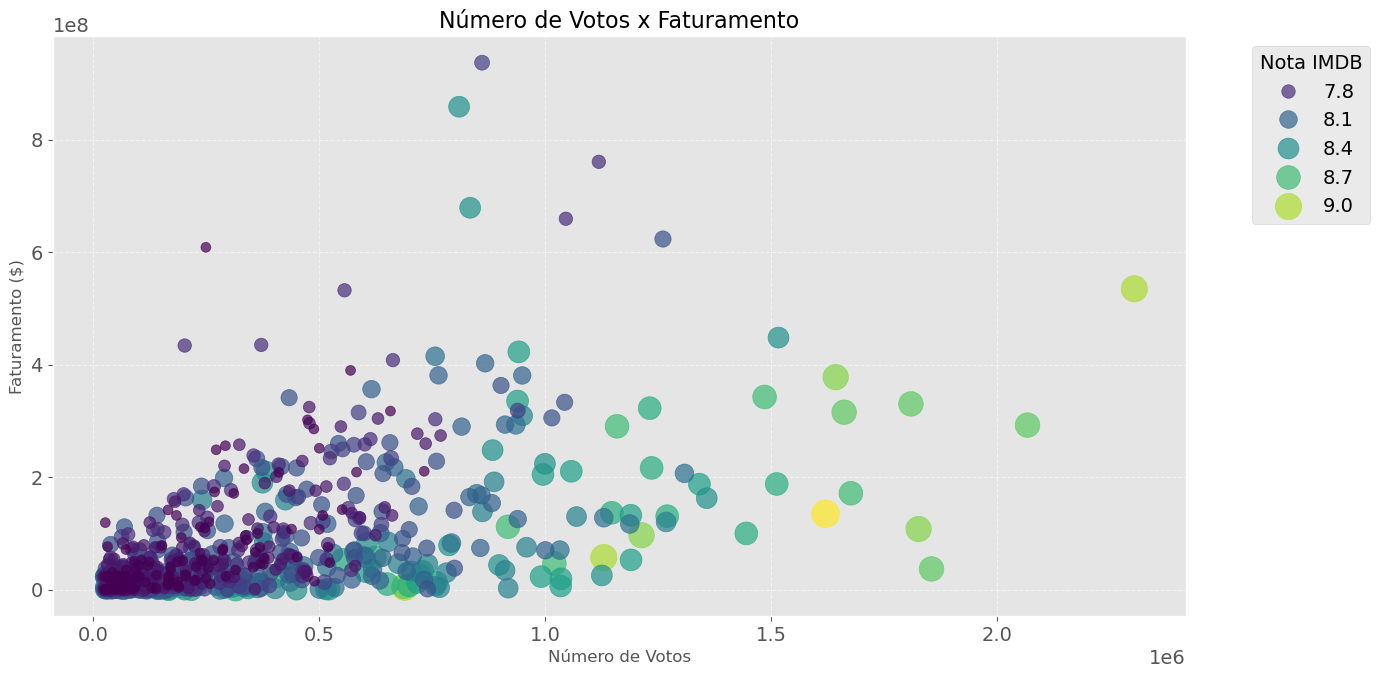

In [29]:
# ---------- Número de Votos x Faturamento ----------
plt.figure(figsize=(14,7))
scatter = sns.scatterplot(
    data=df,
    x='Número de Votos',
    y='Faturamento',
    size='Nota',
    hue='Nota',
    palette='viridis',
    sizes=(50, 400),
    alpha=0.7,
    edgecolor=None
)

plt.title("Número de Votos x Faturamento")
plt.xlabel("Número de Votos")
plt.ylabel("Faturamento ($)")
plt.grid(linestyle='--', alpha=0.5)

# Ajuste da legenda
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[:], labels=labels[:], title="Nota IMDB", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- **Filmes com poucos votos, alto faturamento e nota próxima a 8:** Esse grupo sugere produções que, apesar de não terem o maior engajamento do público, conseguiram alto retorno financeiro e mantiveram uma avaliação positiva. Possivelmente são blockbusters, lançamentos com forte apelo comercial ou filmes que atraíram grandes audiências, mas não geraram tanto engajamento em plataformas de avaliação.

- **Poucas bolhas com nota IMDB próxima a 9, faturamento não tão alto e muitos votos:** Filmes com altíssima avaliação tendem a ser obras cultuadas, clássicos ou títulos de nicho que conquistam a crítica e o público engajado, mas não necessariamente atingem grandes receitas. Isso pode indicar que excelência artística e reconhecimento crítico nem sempre se traduzem em sucesso comercial massivo.

- **Relação entre engajamento e faturamento:** O gráfico mostra que o engajamento do público (número de votos) não é diretamente proporcional ao faturamento. Filmes populares podem gerar muitos votos sem necessariamente serem os mais rentáveis, enquanto grandes receitas podem ser obtidas por títulos com menor participação nas avaliações.

- **Oportunidade para estratégias de marketing:** Investir em campanhas que ampliem o engajamento do público pode potencializar o reconhecimento de filmes rentáveis, enquanto obras de alta avaliação podem se beneficiar de estratégias para ampliar seu alcance comercial.

**Conclusão:** Grandes receitas podem vir de títulos com engajamento limitado, enquanto obras de excelência podem conquistar multidões sem atingir faturamento recorde. O equilíbrio entre qualidade, engajamento e retorno financeiro é o verdadeiro desafio e oportunidade para produtores e distribuidores inovarem no mercado cinematográfico.

#### 3.5.2 Número de votos vs. Faturamento utilizando Weighted Rating (WR)

**Objetivo:** Confirmar se número de votos está correlacionado com faturamento e identificar padrões de retorno por popularidade

**Métricas:** 

- Eixo X: Número de votos
- Eixo Y: Faturamento
- Tamanho e cor da bolha: Weighted Rating (WR)

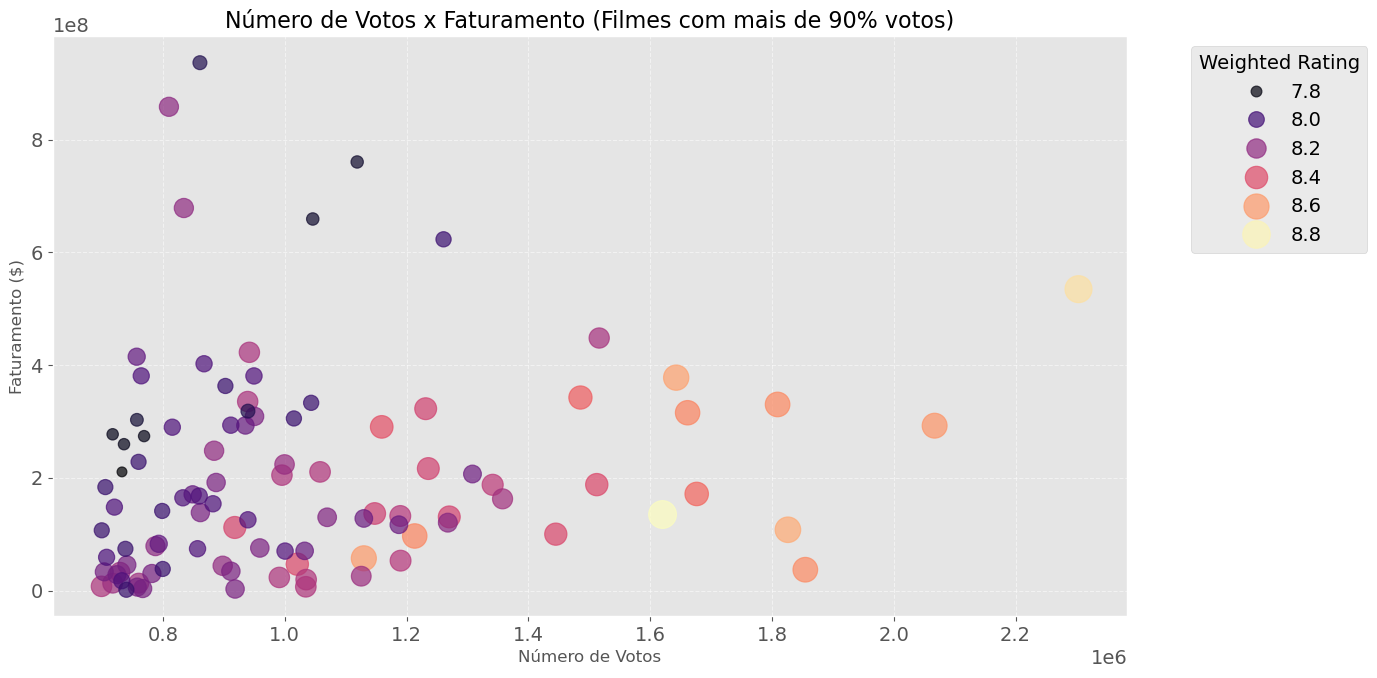

In [30]:
# ---------- Número de votos x Faturamento utilizando Weighted Rating ----------
plt.figure(figsize=(14,7))
scatter = sns.scatterplot(
    data=df_filtrado,
    x='Número de Votos',
    y='Faturamento',
    size='WR',
    hue='WR',
    palette='magma',
    sizes=(50, 400),
    alpha=0.7,
    edgecolor=None
)
plt.title("Número de Votos x Faturamento (Filmes com mais de 90% votos)")
plt.xlabel("Número de Votos")
plt.ylabel("Faturamento ($)")
plt.grid(linestyle='--', alpha=0.5)
# Ajuste da legenda
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[:], labels=labels[:], title="Weighted Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Conclusão:** Foi observado um comportamento bastante semelhante ao gráfico que considera apenas as notas do IMDB, o que indica que mesmo considerando os pesos dos votos para averiguar a popularidade, grandes bilheterias não são diretamente proporcionais às notas dos filmes.

## 4.0 Correlação e drivers de faturamento

#### 4.1 Matriz de correlação

**Objetivo:** Identificar as relações entre as variáveis numéricas

**Métrica:** Correlação de Pearson

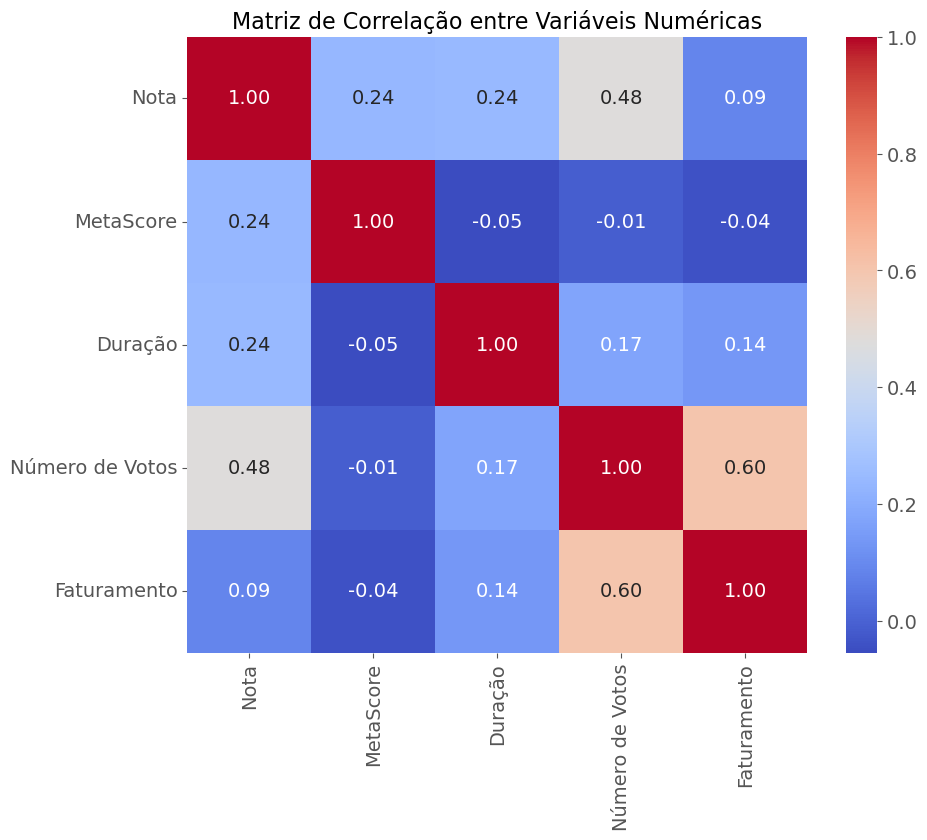

In [31]:
# ---------- Matriz de Correlação ----------
plot_correlation_matrix(
    df,
    cols=['Nota', 'MetaScore', 'Duração', 'Número de Votos', 'Faturamento'],
    title='Matriz de Correlação entre Variáveis Numéricas'
)


- **Nota IMDB** tem correlação moderada com **Número de Votos (0.48)** e fraca com **Duração (0.24)** e **MetaScore (0.23)**. Isso indica que a percepção do público é influenciada principalmente pelo engajamento e, em menor grau, por críticas profissionais ou extensão do filme.

- **Faturamento** apresenta forte correlação com **Número de Votos (0.60)**, mas quase nenhuma relação com Nota IMDB ou MetaScore. Ou seja, sucesso financeiro depende mais da popularidade e engajamento do público do que da avaliação crítica.

- **MetaScore** tem impacto marginal tanto sobre Nota quanto sobre Faturamento, mostrando que filmes bem avaliados pelos críticos não necessariamente atingem altos faturamentos ou notas elevadas do público.

- **Duração:** Correlações baixas, mas positivas, sugerem que filmes mais longos tendem a ser um pouco mais bem avaliados e rentáveis, porém sem grande impacto.

**Conclusão:** Para recomendações de filmes ou previsão de sucesso financeiro, o foco deve ser em métricas de engajamento (Número de Votos, Popularidade), mais do que apenas na crítica especializada.

#### 4.2 Drivers de faturamento

**Objetivo:** Identificar os fatores mais relevantes que impactam o sucesso financeiro dos filmes

**Métrica:** Importância das features extraída de um Random Forest Regressor; avaliação adicional via R², RMSE e MAE para mensurar a qualidade do modelo

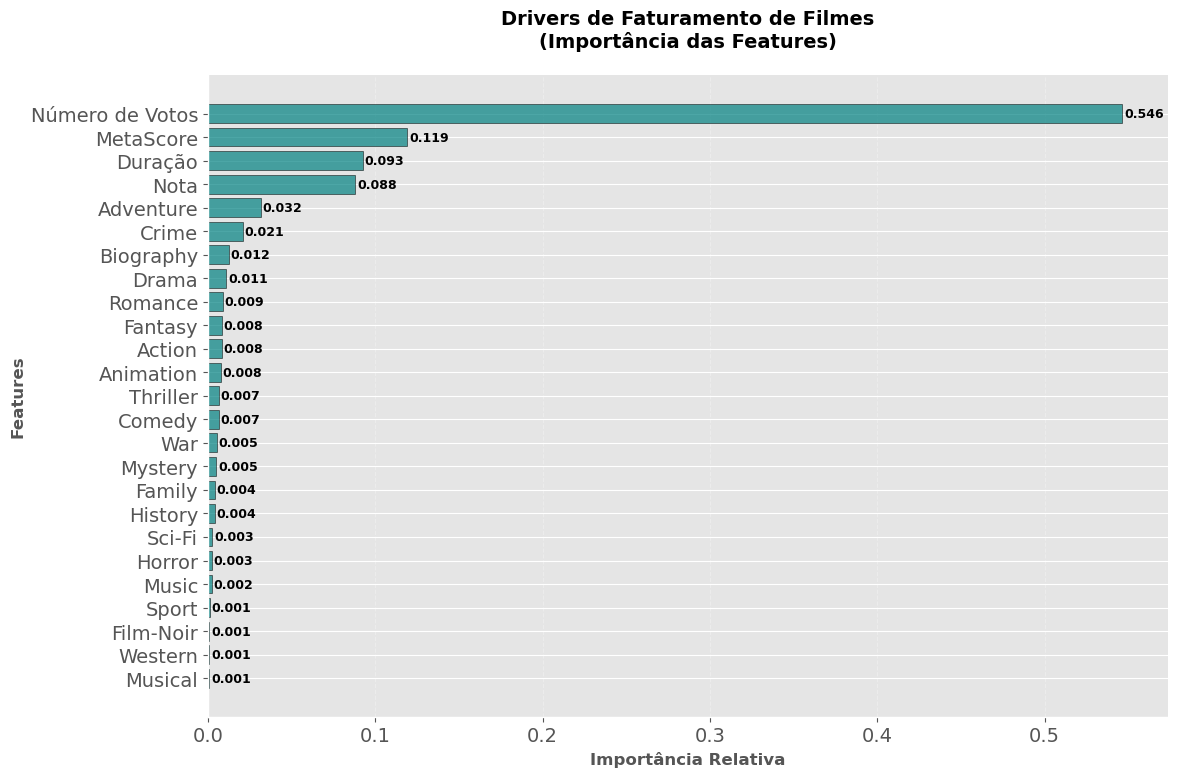

In [32]:
# ---------- Feature Importance com Random Forest ----------
# Features e target
features = ['Nota', 'MetaScore', 'Número de Votos', 'Duração'] + list(generos_dummies.columns)
target = 'Faturamento'

X = df[features]
y = np.log1p(df[target])  # log-transform para lidar com outliers

# Pipeline
preprocessor = ColumnTransformer(transformers=[('all', 'passthrough', features)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42))
])

# Treinar modelo
pipeline.fit(X, y)

# Importância das features
importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance = pd.Series(importances, index=features)
feature_importance = feature_importance.sort_values(ascending=True)  # Ordenar para o gráfico

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance.index, feature_importance.values,
                color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('Importância Relativa', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Drivers de Faturamento de Filmes\n(Importância das Features)', 
          fontsize=14, fontweight='bold', pad=20)

# Adicionar valores nas barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold',
             fontsize=9, color='black')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.tight_layout()
plt.show()

- **Número de Votos** é o principal driver do faturamento (54,6%), indicando que a receita de um filme depende muito mais do engajamento e popularidade do público do que de críticas ou notas.  

- **MetaScore** (11,9%) e **Nota IMDB** (8,8%) aparecem como fatores secundários. Apesar de poderem apresentar data leakage, seu impacto é menor, mostrando que avaliações críticas não são determinantes para o sucesso financeiro.  

- **Duração** contribui de forma moderada (9,3%), sugerindo que filmes mais longos podem gerar ligeiramente mais receita, mas não de forma decisiva.  

- Entre os gêneros, Aventura (3,2%) e Crime (2,1%) apresentam alguma influência, enquanto outros gêneros individuais têm efeito residual (<2%).  

**Conclusão:** O foco para estratégias de sucesso financeiro deve estar em métricas de engajamento do público, como Número de Votos, ao invés de apenas depender de notas ou críticas. O investimento em marketing, alcance e construção de audiência é mais relevante para maximizar faturamento do que a avaliação crítica isolada.

## 5.0 Insights aplicados

#### 5.1 Recomendação de filmes a desconhecidos

Conforme observado na análise exploratória dos dados, a nota IMDB e a nota Meta Score, além do número de votos em plataformas, não são sinônimos diretos da aprovação popular de um filme. Entre os parâmetros avaliados, filmes com alto faturamento possuem aprovação popular massiva, indicando que este é um bom parâmetro de popularidade. Entre os gêneros de maior aprovação popular, destacam-se os gêneros Aventura, Ação e Ficção Científica por apresentarem, além da aceitabilidade do público, boas notas de avaliações.

Logo, os critérios que vou considerar para recomendar um filme para uma pessoa desconhecida são:

- Faturamento: conforme observado na análise explorátoria, é um bom indicativo de popularidade e aceitação, possuindo um peso maior para a avaliação (item 3.4.1 - Filmes com maior faturamento).

- Gênero: existe uma aceitabilidade e aprovação maior do público para os gêneros Aventura, Ação e Ficção Científica, mesmo estes possuindo avaliações menos impactantes da crítica em geral (item 3.3.2 - Nota média de faturamento por gênero).

- Compatibilidade de público: classificação indicativa garante que o filme é adequado para qualquer pessoa.

- Nota: a nota é um bom parâmetro de qualidade dos filmes, mesmo não estando diretamente relacionada à aprovação popular e ao faturamento. Apesar de ser relevante, a distribuição das notas do dataset sugere que houve uma pré-seleção de filmes, apresentando pouca variabilidade (item 3.0 - Distribuição de nota).

- Diretor: alguns diretores estão constantemente produzindo filmes relevantes e de impacto popular (item 3.2.3 e 3.2.4).

- Ator: alguns atores são populares muito populares e sempre aparecem em filmes de grande impacto (item 3.2.1, 3.2.5, 3.2.6 e item 3.4.1)

In [33]:
#---------- Top 10 filmes recomendados com base na análise exploratória de dados (EDA) ----------


# Popularidade dos Atores (soma de votos dos filmes do EDA)
ator_pop = {}
for star in ['Star1','Star2','Star3','Star4']:
    tmp = df.groupby(star)['Número de Votos'].sum().to_dict()
    for k,v in tmp.items():
        ator_pop[k] = ator_pop.get(k,0) + v

# Diretores com +5 filmes (Nº de filmes × Nota média)
df_dir = df.groupby('Diretor').agg({'Nome do Filme':'count','Nota':'mean'})
df_dir = df_dir[df_dir['Nome do Filme']>5]
df_dir['score_diretor'] = df_dir['Nome do Filme'] * df_dir['Nota']
diretor_score = df_dir['score_diretor'].to_dict()

# Média de faturamento por gênero (múltiplos gêneros por linha)
genero_faturamento = defaultdict(list)
for idx, row in df.iterrows():
    generos = str(row['Gênero']).split('|')
    for g in generos:
        genero_faturamento[g].append(row['Faturamento'])
genero_faturamento_avg = {g:sum(v)/len(v) for g,v in genero_faturamento.items()}

# Gêneros mais aceitos pelo público (observado no EDA)
generos_populares = {"Action", "Adventure", "Sci-Fi"}

# Função de pontuação combinada baseada no EDA e critérios
def pontuacao_eda_pesos(row):
    # Faturamento (peso maior)
    score_revenue = row['Faturamento'] / df['Faturamento'].max()
    
    # Gênero (vantagem extra para Aventura, Ação e Sci-Fi)
    generos = str(row['Gênero']).split('|')
    score_genero = sum([genero_faturamento_avg.get(g,0) for g in generos]) / (len(generos) * max(genero_faturamento_avg.values()))
    if any(g in generos_populares for g in generos):
        score_genero *= 1.2  # bônus para gêneros populares
    
    # Nota (qualidade, mas peso menor que faturamento e gênero)
    score_rating = row['Nota'] / 10 if row['Nota'] > 0 else 0
    
    # Diretor
    score_diretor = diretor_score.get(row['Diretor'], 0)
    score_diretor = score_diretor / max(diretor_score.values()) if diretor_score else 0
    
    # Atores
    score_atores = sum([ator_pop.get(row[s],0) for s in ['Star1','Star2','Star3','Star4']])
    score_atores = score_atores / max(ator_pop.values()) if ator_pop else 0
    
    # Combinação ponderada pelos critérios do EDA
    total_score = (
        score_revenue*0.40 + 
        score_genero*0.25 + 
        score_rating*0.15 + 
        score_diretor*0.10 + 
        score_atores*0.10
    )
    return total_score

# Filtragem básica: público geral (compatibilidade universal)
publico_geral = ['U', 'A', 'UA', 'PG', 'PG-13', 'G', 'Approved', 'Passed', 'U/A']
top_filmes = df[df['Classificação Indicativa'].isin(publico_geral)].copy()

# Calculo pontuação
top_filmes['Pontuacao_EDA'] = top_filmes.apply(pontuacao_eda_pesos, axis=1)

# Ordenar e pegar top 10
top_filmes = top_filmes.sort_values('Pontuacao_EDA', ascending=False).head(10)

# Selecionar colunas para exibição
cols = ['Nome do Filme', 'Gênero', 'Classificação Indicativa', 'Número de Votos', 
        'Faturamento', 'Nota', 'MetaScore', 'Diretor', 
        'Star1', 'Star2', 'Star3', 'Star4', 'Pontuacao_EDA']
top_filmes = top_filmes[cols]

# Exibir
for i, row in top_filmes.iterrows():
    print("="*70)
    print(f"🎬 Filme: {row['Nome do Filme']}")
    print(f"📌 Gênero(s): {row['Gênero']} | Classificação: {row['Classificação Indicativa']}")
    print(f"⭐ Nota IMDB: {row['Nota']} | MetaScore: {row['MetaScore']}")
    print(f"👥 Número de Votos: {row['Número de Votos']:,}")
    print(f"💰 Faturamento: ${row['Faturamento']:,}")
    print(f"🎥 Diretor: {row['Diretor']}")
    print(f"🎭 Atores: {row['Star1']}, {row['Star2']}, {row['Star3']}, {row['Star4']}")
    print(f"📊 Pontuação combinada (EDA ajustada): {row['Pontuacao_EDA']:.4f}")
    print("="*70, "\n")


🎬 Filme: Avengers: Endgame
📌 Gênero(s): Action, Adventure, Drama | Classificação: UA
⭐ Nota IMDB: 8.4 | MetaScore: 78.0
👥 Número de Votos: 809,955
💰 Faturamento: $858,373,000.0
🎥 Diretor: Anthony Russo
🎭 Atores: Joe Russo, Robert Downey Jr., Chris Evans, Mark Ruffalo
📊 Pontuação combinada (EDA ajustada): 0.7611

🎬 Filme: Star Wars: Episode VII - The Force Awakens
📌 Gênero(s): Action, Adventure, Sci-Fi | Classificação: U
⭐ Nota IMDB: 7.9 | MetaScore: 80.0
👥 Número de Votos: 860,823
💰 Faturamento: $936,662,225.0
🎥 Diretor: J.J. Abrams
🎭 Atores: Daisy Ridley, John Boyega, Oscar Isaac, Domhnall Gleeson
📊 Pontuação combinada (EDA ajustada): 0.7300

🎬 Filme: Avatar
📌 Gênero(s): Action, Adventure, Fantasy | Classificação: UA
⭐ Nota IMDB: 7.8 | MetaScore: 83.0
👥 Número de Votos: 1,118,998
💰 Faturamento: $760,507,625.0
🎥 Diretor: James Cameron
🎭 Atores: Sam Worthington, Zoe Saldana, Sigourney Weaver, Michelle Rodriguez
📊 Pontuação combinada (EDA ajustada): 0.7259

🎬 Filme: Avengers: Infinity Wa

### Filme Recomendado: *Avengers: Endgame* (2019)

#### Justificativas:
- **Faturamento**: arrecadou mais de **$858 milhões** apenas nos EUA, evidenciando enorme popularidade.  
- **Gêneros**: combina **Ação, Aventura e Drama**, entre os mais aceitos pelo público geral.  
- **Classificação indicativa**: **UA**, o que permite acesso para a maioria das idades.  
- **Qualidade**: nota **8.4 no IMDB**, mostrando forte aprovação.  
- **Elenco e direção**: participação dos irmãos Russo e um grande time de atores reconhecidos mundialmente ( Joe Russo, Robert Downey Jr., Chris Evans, Mark Ruffalo).

Avengers: Endgame (2019) reúne popularidade, gênero de alta aceitação, classificação acessível e qualidade reconhecida, tornando-se uma escolha segura e universal.


### 5.2 Principais fatores que estão relacionados com alta expectativa de faturamento de um filme

A análise exploratória mostra que o faturamento de um filme depende de uma combinação de fatores que envolvem **contexto histórico, talentos envolvidos, gênero, engajamento do público e drivers quantitativos diretos**.



##### 5.2.1. Contexto histórico e evolução do mercado  
📌 Item 3.1.1

- Observa-se um crescimento consistente do faturamento médio ao longo das décadas, especialmente a partir dos anos 2000, quando os blockbusters e grandes franquias consolidaram o cinema como produto global.  
- Esse crescimento foi impulsionado pelo aumento dos investimentos em produção, pela internacionalização da distribuição e pelo impacto de novas tecnologias (IMAX, 3D, streaming).  

**Insight:** produções mais recentes, com forte apelo tecnológico e global, possuem maior expectativa de retorno financeiro.



##### 5.2.2. Talentos (diretores e atores) como catalisadores de receita  
📌 Itens 3.2.4 e 3.2.6

- Diretores como James Cameron, Peter Jackson e Christopher Nolan apresentam faturamentos médios elevados, associados à criação de universos cinematográficos de grande apelo popular.  
- Do lado dos atores, nomes como Robert Downey Jr., Chris Evans e Daniel Radcliffe demonstram que a associação de um ator a uma franquia pode multiplicar receitas, mesmo com filmografia relativamente curta.  

**Insight:** a combinação de diretores consagrados e atores com histórico de bilheteria aumenta a probabilidade de sucesso comercial imediato, sendo fator estratégico para novos projetos.



##### 5.2.3. Gênero como determinante de bilheteria  
📌 Itens 3.3.2 e 3.3.4

- Filmes de **Aventura, Ficção Científica, Ação e Animação** concentram os maiores faturamentos médios, mesmo sem as notas mais altas.  
- No mapa risco-retorno, estes gêneros aparecem no quadrante de **alto faturamento e maior volatilidade**, indicando apostas de alto risco e alto retorno.  
- Em contrapartida, gêneros como **Drama** ou **Biográficos** apresentam retorno mais estável e eficiente, mesmo sem picos extraordinários.  

**Insight:** para maximizar faturamento, os gêneros Aventura/Ação/Sci-Fi são prioritários, mas projetos de nicho podem ser eficientes em estratégias de diversificação de portfólio.



##### 5.2.4. Popularidade e engajamento como preditores de sucesso  
📌 Itens 3.4.1, 3.5.1 e 4.2

- Filmes com maior número de votos não são necessariamente os mais rentáveis, mas existe correlação significativa entre **engajamento do público e receita**.  
- O número de votos aparece como o **driver mais relevante de faturamento (54,6%)**, superando notas e críticas.  

**Insight:** estratégias de marketing, hype em redes sociais e engajamento digital são determinantes para transformar um filme em fenômeno de bilheteria.



##### 5.2.5. Drivers estatísticos de faturamento  
📌 Item 4.2

- **Número de votos (54,6%)** é o principal driver, superando notas críticas e outros fatores.  
- **MetaScore (11,9%)** e **Nota IMDB (8,8%)** têm efeito secundário, mostrando influência limitada da crítica.  
- **Duração (9,3%)** também apresenta relevância moderada.  
- **Gênero Aventura (3,2%)** aparece como destaque entre categorias.  

**Insight:** os dados reforçam que **engajamento de público > avaliação crítica** quando o objetivo é maximizar faturamento.



##### **Conclusão**

Os fatores mais relacionados com alta expectativa de faturamento de um filme são:  

- Produções recentes com grande apelo global (3.1.1).  
- Diretores consagrados e atores ligados a franquias de sucesso (3.2.4 e 3.2.6).  
- Gêneros de massa como Aventura, Ação e Ficção Científica, mesmo sob maior volatilidade (3.3.2 e 3.3.4).  
- Engajamento e hype do público, traduzido pelo número de votos e interação digital (3.4.1, 3.5.1, 4.2).  
- Drivers estatísticos, com destaque absoluto para o número de votos como proxy de popularidade (4.2).  
- O faturamento depende menos da avaliação crítica isolada e muito mais da capacidade de gerar audiência em larga escala, alavancada por grandes nomes, gêneros populares e estratégias de marketing que maximizem engajamento.


### 5.3 Avaliação da coluna Overview

#### 5.3.1 Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna Overview, renomeada para o dataset de trabalho como Sinopse, apresenta os principais pontos de um filme, como enredo, as personagens e o tema central, sem revelar detalhes que estraguem a experiência do público (espoiler).

A partir do tema central, é possível inferir o gênero do filme por meio da observação de palavras recorrentes dentro do mesmo gênero, como "hero", "battle", "space". Além disso, é possível identificar o público alvo por meio de palavras implícitas como "family", "children", "murder".

Uma das maneira de verificar palavras recorrentes dentro de sinopses de um mesmo gênero é a nuvem de palavras. Por meio da verificação da proporção em que as palavras aparecem, a nuvem de palavrar mostra, de forma visual, quais são as mais utilizadas. Abaixo, apresento a nuvem de palavras para alguns gêneros.

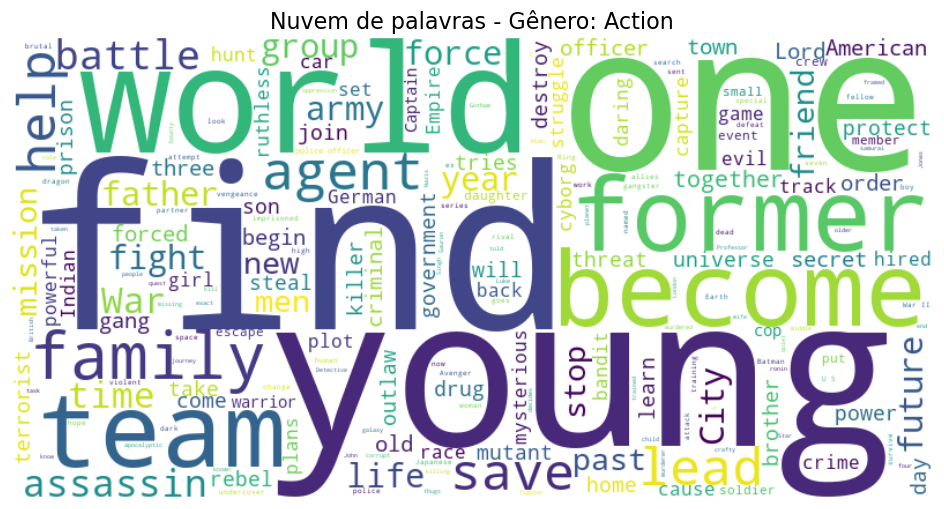

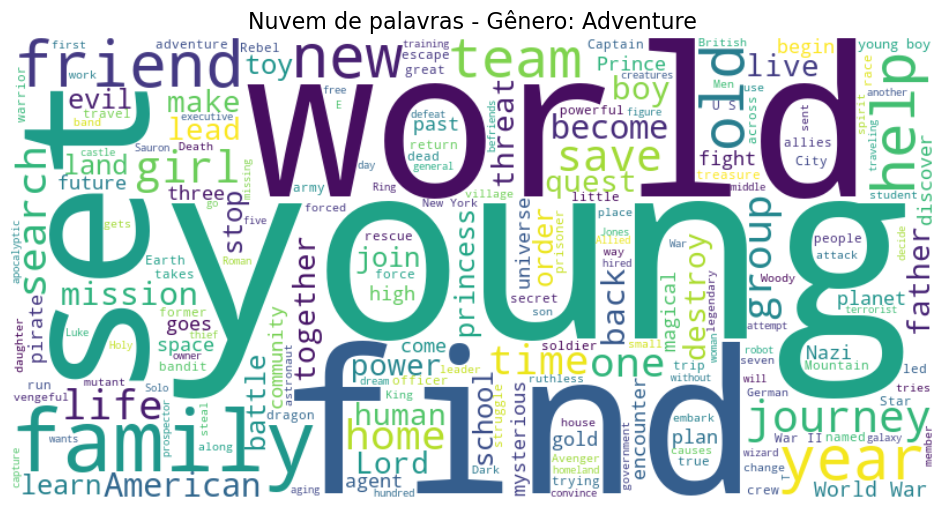

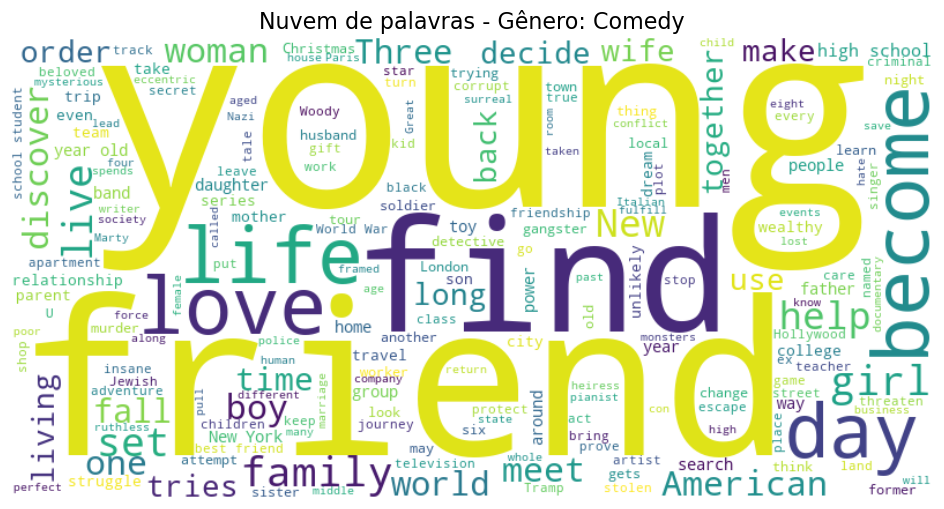

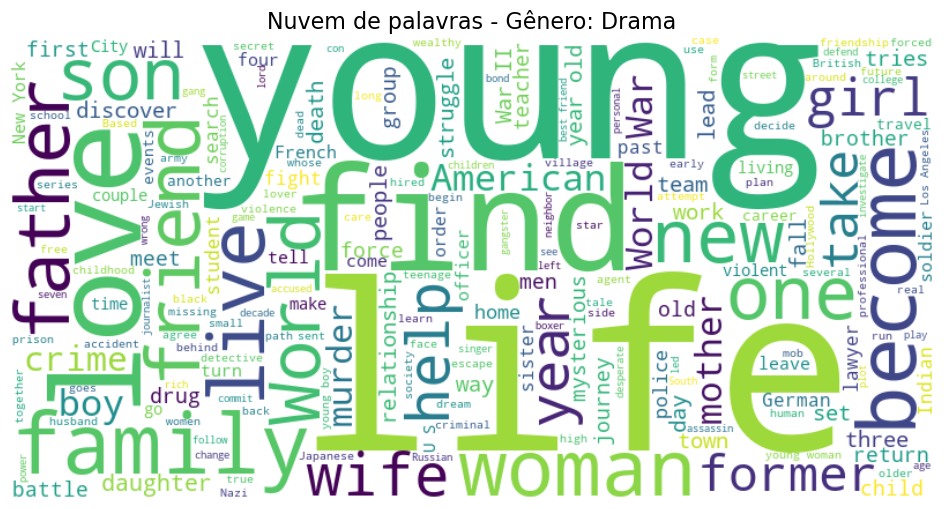

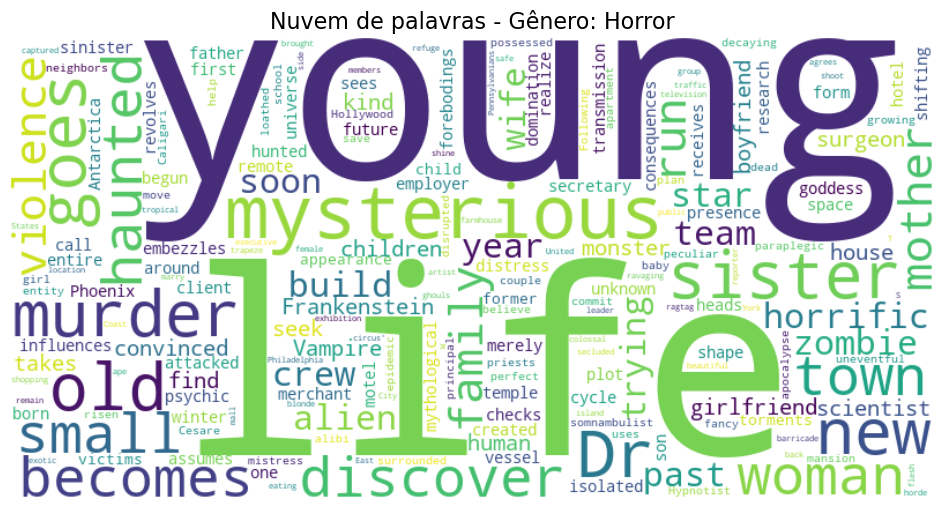

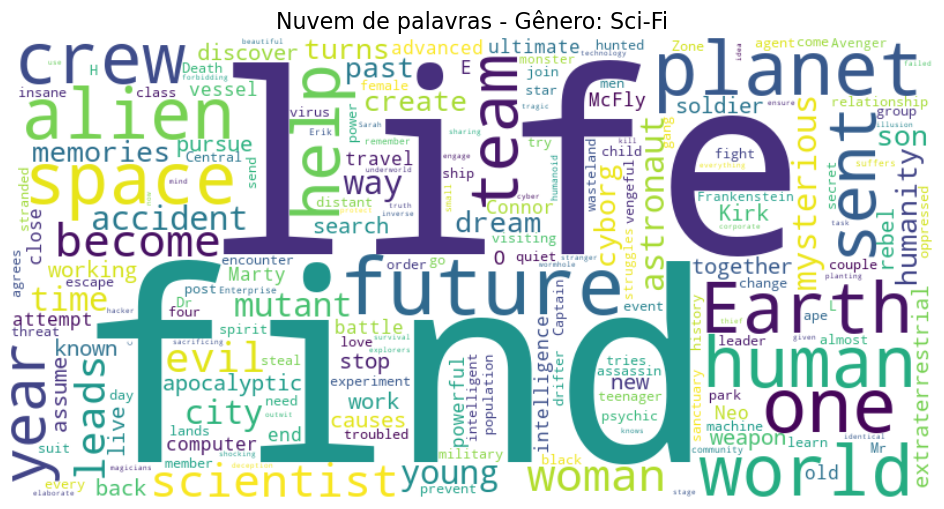

In [34]:
# ---------- Nuvem de palavras por gênero ----------

generos = generos_dummies
minhas_stopwords = set(STOPWORDS).union({'film', 'movie', 'story', 'two', 'man', 'must'})

# Função para gerar nuvem de palavras de um gênero
def nuvem_por_genero(df, genero):
    # Seleciona todas as sinopses dos filmes desse gênero
    textos = df[df[genero]==1]['Sinopse'].dropna().str.cat(sep=' ')
    
    # Cria a nuvem de palavras
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', stopwords=minhas_stopwords).generate(textos)
    
    # Exibe a nuvem
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuvem de palavras - Gênero: {genero}", fontsize=16)
    plt.show()

nuvem_por_genero(df, 'Action')
nuvem_por_genero(df, 'Adventure')
nuvem_por_genero(df, 'Comedy')
nuvem_por_genero(df, 'Drama')
nuvem_por_genero(df, 'Horror')
nuvem_por_genero(df, 'Sci-Fi')

Além da observação visual das palavras mais frequentes, é possível usar métodos de aprendizado de máquina para tentar inferir automaticamente o gênero do filme a partir da sinopse. Para isso, basta transformar as sinopses em vetores numéricos usando TF-IDF e treinar um modelo de classificação multi-rótulo (cada filme pode ter múltiplos gêneros).

In [35]:
# ---------- Inferir gênero de filme a partir da sinopse  ----------

# Definir gêneros
genre_cols = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
              'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

# Preencher nulos na sinopse
X = df['Sinopse'].fillna('')
y = df[genre_cols]

# Transformar texto em vetores TF-IDF
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Treinar modelo multi-label com OneVsRest e Logistic Regression balanceada
clf = OneVsRestClassifier(LogisticRegression(max_iter=500, class_weight='balanced'))
clf.fit(X_train, y_train)

# Predições
y_pred = clf.predict(X_test)

# Avaliar performance por gênero
report = classification_report(y_test, y_pred, target_names=genre_cols, zero_division=0)
print(report)




              precision    recall  f1-score   support

      Action       0.50      0.29      0.37        34
   Adventure       0.67      0.25      0.36        40
   Animation       0.60      0.17      0.26        18
   Biography       0.36      0.20      0.26        25
      Comedy       0.43      0.33      0.37        46
       Crime       0.60      0.35      0.44        43
       Drama       0.84      0.88      0.86       157
      Family       0.14      0.20      0.17         5
     Fantasy       0.50      0.11      0.18         9
   Film-Noir       0.00      0.00      0.00         3
     History       0.00      0.00      0.00         8
      Horror       1.00      0.10      0.18        10
       Music       0.33      0.11      0.17         9
     Musical       0.00      0.00      0.00         4
     Mystery       0.83      0.22      0.34        23
     Romance       0.25      0.14      0.18        21
      Sci-Fi       1.00      0.18      0.31        11
       Sport       0.00    

In [36]:
# Teste rápido de uma nova sinopse do data set
nome_do_filme = "Avengers: Endgame"
nova_sinopse = df['Nome do Filme']==nome_do_filme
nova_sinopse = df.loc[nova_sinopse, 'Sinopse'].values
nova_tfidf = vectorizer.transform(nova_sinopse)
pred_generos = clf.predict(nova_tfidf)
pred_generos_df = pd.DataFrame(pred_generos, columns=genre_cols)
print("\nPredição de gênero para a nova sinopse:")
print(pred_generos_df.T[pred_generos_df.T[0]==1])


Predição de gênero para a nova sinopse:
           0
Action     1
Adventure  1
Drama      1


O modelo multi-rótulo simples apresentado acima (Logistic Regression + TF-IDF) mostrou que é possível inferir o gênero a partir da sinopse, mas apresentou limitações claras:

- **Bom desempenho em gêneros frequentes:** `Drama` e `Comedy` apresentam F1-score razoável.  
- **Desempenho ruim em gêneros raros:** `Film-Noir`, `Musical`, `Western` quase não foram identificados.  
- **Problema de desbalanceamento:** Classes com poucos exemplos são preditas com baixa precisão e recall, e classes com muitos exemplos tendem a serem usadas na maioria das predições (como Drama).  
- **Limitação do TF-IDF:** Captura palavras-chave, mas não contexto ou semântica entre termos.

Melhorias técnicas possíveis

1. **Modelos avançados de NLP:** Usar embeddings/contextualizados (BERT, RoBERTa)  para capturar significado e contexto das palavras.  
2. **Ajuste de thresholds por gênero:** Melhorar recall em classes minoritárias.  
3. **Tratamento de desbalanceamento:** Oversampling, undersampling ou técnicas de weighting mais sofisticadas do que as usadas no modelo atual.  
4. **Engenharia de features adicionais:** Bigramas, entidades (personagens, locais) ou palavras-chave específicas por gênero.  
5. **Aumento da base de dados:** Coletar mais exemplos de gêneros com poucos filmes.

O modelo atual é uma prova de conceito; para aplicação real, é necessário um modelo mais robusto que capture contexto, trate desbalanceamento e use técnicas avançadas de NLP.


### 6.0 Previsão de Notas IMDB

#### 6.1 Definição do problema e tipo de modelagem

#### 6.1.1 Seleção e Transformação das Variáveis para Previsão da Nota do IMDb

1. Variáveis Numéricas

- **MetaScore**: Forte correlação esperada com a nota do público.

    Transformação: Padronização StandardScaler para compatibilizar a escala com outras variáveis numéricas.

- **Número de Votos**: Indicador de popularidade e engajamento do público.

    Transformação: Aplicação de logaritmo natural para reduzir assimetria da distribuição.

- **Duração**: Tempo de duração do filme em minutos.

    Transformação: Já foi convertido de string para numérico (ex: `"142 min"` → `142`).

- **Ano de Lançamento**: Pode capturar tendências temporais e evolução dos padrões cinematográficos.

    Transformação: Será mantido como valor numérico contínuo.

- **Faturamento:** Representa o sucesso comercial do filme, podendo refletir a popularidade junto ao público e a repercussão do lançamento.

    Transformação: Conversão de string para numérico (remoção de $ e ,) e aplicação do logaritmo natural para reduzir assimetria na distribuição, aproximando a variável de uma escala mais normalizada para o modelo.


2. Variáveis Categóricas

- **Gênero**: Já processado com one-hot encoding para categorias binárias.

    Transformação: Serão mantidas as variáveis binárias já criadas.

- **Diretor**: Influência significativa na qualidade e estilo do filme.

    Transformação: Target Encoding com validação cruzada para substituir pelo valor médio da nota IMDb dos filmes do diretor, evitando alta cardinalidade.

- **Atores Principais (Star1, Star2, Star3, Star4)**: Impacto no apelo comercial e performance artística.

    Transformação: Target Encoding com validação cruzada para cada ator principal, calculando a média da nota IMDb dos filmes de cada ator.


3. Variáveis Não Utilizadas

- **Classificação Indicativa**: Pouco poder preditivo demonstrado na análise exploratória.

- **Nota**: Variável target que será predita (Nota IMDb). Não é usada como feature no modelo de regressão para evitar data leakage, mas serve como referência para calcular métricas de performance como MAE, RMSE e R².

- **Sinopse (Overview)**: Contém informações textuais potencialmente relevantes, mas exigiria processamento de linguagem natural (NLP) complexo. Por restrição de tempo e simplicidade do modelo, esta variável não foi utilizada.

- **Nome do filme**: Identificador único que não apresenta padrão numérico ou categórico relevante para aprendizado direto.

#### 6.1.2 Tipo de Problema

- O problema que estamos resolvendo é **REGRESSÃO**, pois o objetivo é prever uma nota numérica do IMDb (variável alvo `Nota`) que é contínua, ou seja, que varia de 0 a 10. Diferente de classificação, não estamos categorizando filmes em classes, mas estimando valores reais.


- O modelo que melhor se aproxima dos dados é o **XGBoost Regressor**, um algoritmo de **Gradient Boosting** baseado em árvores. 

- O XGBoost Regessor apresenta os seguintes pontos positivos:

    - Capaz de lidar com **relações não lineares** e interações complexas entre variáveis.  
    - Lida bem com variáveis numéricas e categóricas após transformação.  
    - Regularização interna ajuda a reduzir overfitting.  
    - Boa performance em datasets de tamanho moderado, como o dataset utilizado neste projeto, que possui 999 linhas.

Em contra partida, alguns pontos de atenção devem ser tomados. São eles:

    - Requer ajuste de hiperparâmetros para alcançar o melhor desempenho.  
    - Difícil de interpretar comparado a modelos lineares simples.  
    - Necessita de pré-processamento consistente, principalmente para features categóricas com encoding e log-transformação.  


**Medida de Performance**

Foram escolhidas as seguintes métricas:  

- **MAE (Mean Absolute Error)**: fornece o erro médio absoluto entre notas previstas e reais. Fácil de interpretar em termos de “quantos pontos a previsão erra em média”.

- **R² Score**: indica a proporção da variabilidade da nota explicada pelo modelo, oferecendo uma visão da qualidade global do ajuste.

- **RMSE via Validação Cruzada (5-fold)**: usada para medir o erro quadrático médio e estabilidade do modelo em diferentes divisões do dataset, penalizando mais erros grandes.  

Deses modo, o MAE e o RMSE permitem compreender o erro médio em termos de nota, enquanto R² mostra o quanto do comportamento real do IMDb o modelo consegue capturar. O uso de validação cruzada (cross-validation) garante que a avaliação seja robusta e generalizável para novos filmes.


#### 6.2 Construção do modelo de Previsão de Nota

In [37]:
# ---------- Target Encoding para Diretor e Atores ----------
# Função para aplicar target encoding nas colunas categóricas "diretor" e "atores" (star1, star2, star3, star4)
def target_encoding(df, column, target='Nota', n_split=5):
    """"
    Aplicar target encoding com K-Fold para evitar vazamento de dados.
    """

    df_encoded = pd.Series(index=df.index, dtype=float)
    kf = KFold(n_splits=n_split, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(df):
        # Média do target no conjunto de treino
        mean_target = df.iloc[train_index].groupby(column)[target].mean()
        # Mapear para o conjunto de validação
        df_encoded.iloc[val_index] = df.iloc[val_index][column].map(mean_target)
    # Preencher nulos com a média global do target
    df_encoded.fillna(df[target].mean(), inplace=True)
    return df_encoded


In [38]:
# ---------- Aplicar target encoding ----------
# ---------- Criar cópia do dataframe original ----------
df_pred = df.copy()
# ---------- Aplicar target encoding para diretor ----------
df_pred['Diretor_TE'] = target_encoding(df_pred, 'Diretor', target='Nota', n_split=5)
# ---------- Aplicar target encoding para atores ----------
for star in ['Star1', 'Star2', 'Star3', 'Star4']:
    df_pred[f'{star}_TE'] = target_encoding(df_pred, star, target='Nota', n_split=5)
# Verificar resultado
df_pred[['Diretor', 'Diretor_TE', 'Star1', 'Star1_TE', 'Star2', 'Star2_TE']].head(10)

Diretor  Diretor_TE              Star1  Star1_TE                 Star2  Star2_TE
0  Francis Ford Coppola        7.70      Marlon Brando      8.10             Al Pacino      7.80
1     Christopher Nolan        8.30     Christian Bale      7.82          Heath Ledger      7.95
2  Francis Ford Coppola        7.70          Al Pacino      7.90        Robert De Niro      8.35
3          Sidney Lumet        7.88        Henry Fonda      8.25           Lee J. Cobb      7.95
4         Peter Jackson        8.28        Elijah Wood      8.75       Viggo Mortensen      7.60
5     Quentin Tarantino        8.12      John Travolta      7.95           Uma Thurman      7.80
6      Steven Spielberg        7.96        Liam Neeson      7.80         Ralph Fiennes      7.95
7     Christopher Nolan        8.52  Leonardo DiCaprio      8.03  Joseph Gordon-Levitt      7.70
8         David Fincher        7.82          Brad Pitt      7.95         Edward Norton      7.95
9         Peter Jackson        8.30        Elijah Wood      8.80          Ian McKellen      8.25

In [39]:
# ---------- Modelo de Predição de Nota do Filme (Regressão) ----------

# Features e target
target = 'Nota'
numeric_features = ['Ano de Lançamento', 'Duração', 'MetaScore', 'Faturamento']
votes_feature = ['Número de Votos']
encoded_features = ['Diretor_TE', 'Star1_TE', 'Star2_TE', 'Star3_TE', 'Star4_TE']
gen_features = list(generos_dummies.columns)

features = numeric_features + votes_feature + encoded_features + gen_features

# Pipeline
# Transformação logaritmica para Número de Votos
log_transformer = FunctionTransformer(np.log1p, validate=False)
votes_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', log_transformer),
    ('scaler', StandardScaler())
])

# Pré-processamento para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ColumnTransformer para aplicar transformações específicas
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('votes', votes_transformer, votes_feature),
    ('genre', 'passthrough', gen_features),
    ('encoded', 'passthrough', encoded_features)
])

# Pipeline completo do modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        max_depth=1, 
        random_state=42,
        learning_rate=0.2))
])

# Dividir treino e teste
X = df_pred[features]
y = df_pred[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Treinar modelo
model.fit(X_train, y_train)

# Predições
y_pred = model.predict(X_test)

# Avaliar performance
print("Avaliação do Modelo de Regressão para Predição de Nota do Filme:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

# Validação cruzada
cv_scores = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42),scoring='neg_root_mean_squared_error')

print(f"\nRMSE Validação Cruzada (5-folds): {-cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Avaliação do Modelo de Regressão para Predição de Nota do Filme:
MAE: 0.1603
R² Score: 0.3865

RMSE Validação Cruzada (5-folds): 0.1961 (±0.0067)


In [40]:
# ---------- Função para prever a nota de um novo filme ----------
def prever_nota_filme(dados_filme, modelo, df_treino, generos_dummies):
    """
    Prepara os dados e faz a predição da nota IMDb para um novo filme
    """
    # Criar DataFrame com os dados do novo filme
    df_novo = pd.DataFrame([dados_filme])
    
    # Converter dados para o formato correto
    df_novo['Ano de Lançamento'] = df_novo['Released_Year'].astype(int)
    df_novo['Duração'] = df_novo['Runtime'].str.replace(' min', '').astype(int)
    df_novo['Número de Votos'] = df_novo['No_of_Votes'].astype(int)
    df_novo['MetaScore'] = df_novo['Meta_score'].astype(float)
    df_novo['Faturamento'] = df_novo['Gross'].str.replace('$', '').str.replace(',', '').astype(float)
    
    # Aplicar Target Encoding (usando médias do treino)
    df_novo['Diretor_TE'] = df_treino[df_treino['Diretor'] == dados_filme['Director']]['Nota'].mean()
    df_novo['Star1_TE'] = df_treino[df_treino['Star1'] == dados_filme['Star1']]['Nota'].mean()
    df_novo['Star2_TE'] = df_treino[df_treino['Star2'] == dados_filme['Star2']]['Nota'].mean()
    df_novo['Star3_TE'] = df_treino[df_treino['Star3'] == dados_filme['Star3']]['Nota'].mean()
    df_novo['Star4_TE'] = df_treino[df_treino['Star4'] == dados_filme['Star4']]['Nota'].mean()
    
    # Preencher NaN com média global se algum diretor/ator não existir no treino
    media_global = df_treino['Nota'].mean()
    for col in ['Diretor_TE', 'Star1_TE', 'Star2_TE', 'Star3_TE', 'Star4_TE']:
        df_novo[col].fillna(media_global, inplace=True)
    
    # One-Hot Encoding para gênero
    genero_lista = list(generos_dummies.columns)
    for genero in genero_lista:
        df_novo[genero] = 0
    
    # Marcar o gênero do filme atual
    genero_filme = dados_filme['Genre']
    if genero_filme in [g.replace('Genre_', '') for g in genero_lista]:
        col_genero = f"Genre_{genero_filme}"
        if col_genero in df_novo.columns:
            df_novo[col_genero] = 1
    
    # Selecionar as features na ordem correta
    features = ['Ano de Lançamento', 'Duração', 'MetaScore',
               'Diretor_TE', 'Star1_TE', 'Star2_TE', 'Star3_TE', 'Star4_TE', 'Número de Votos', 'Faturamento'] + genero_lista
    
    X_novo = df_novo[features]
    
    # Fazer a predição
    nota_predita = modelo.predict(X_novo)[0]
    
    return round(nota_predita, 2)


In [41]:
# ---------- Prever a nota do filme sugerido na tarefa ----------
filme = {'Series_Title': 'The Shawshank Redemption',
        'Released_Year': '1994',
        'Certificate': 'A',
        'Runtime': '142 min',
        'Genre': 'Drama',
        'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
        'Meta_score': 80.0,
        'Director': 'Frank Darabont',
        'Star1': 'Tim Robbins',
        'Star2': 'Morgan Freeman',
        'Star3': 'Bob Gunton',
        'Star4': 'William Sadler',
        'No_of_Votes': 2343110,
        'Gross': '28,341,469'}

nota_predita = prever_nota_filme(filme, model, df_pred, generos_dummies)
print(f"Nota predita para '{filme['Series_Title']}': {nota_predita:.2f}/10")


Nota predita para 'The Shawshank Redemption': 9.10/10


In [42]:
# ---------- Prever a nota do filme brasileiro aleatório ----------
filme_brasil = {'Series_Title': 'O Cheiro do Ralo',
        'Released_Year': '2006',
        'Certificate': 'A',
        'Runtime': '112 min',
        'Genre': 'Drama, Comédia',
        'Overview': 'A pawn shop proprietor buys used goods from desperate locals as much to play perverse power games as for his own livelihood, but when the perfect rump and a backed-up toilet enter his life, he loses all control.',
        'Meta_score': 28.0,
        'Director': 'Heitor Dhalia',
        'Star1': 'Selton Mello',
        'Star2': 'Paula Braun',
        'Star3': 'Paulo Alves',
        'Star4': 'Lourenço Mutarelli',
        'No_of_Votes': 52000,
        'Gross': '786,460'}

nota_predita_brasil = prever_nota_filme(filme_brasil, model, df_pred, generos_dummies)
print(f"Nota predita para '{filme_brasil['Series_Title']}': {nota_predita_brasil:.2f}/10")

Nota predita para 'O Cheiro do Ralo': 7.68/10


In [43]:
# ---------- Prever a nota de algum filme aleatório ----------
filme_aleatorio = {'Series_Title': 'Das Leben der Anderen',
        'Released_Year': '2006',
        'Certificate': 'M',
        'Runtime': '137 min',
        'Genre': 'Drama, Thriller',
        'Overview': 'In 1984 East Berlin, an agent of the secret police conducting surveillance on a writer and his lover finds himself becoming increasingly absorbed by their lives.',
        'Meta_score': 89.0,
        'Director': 'Florian Henckel von Donnersmarck',
        'Star1': 'Ulrich Mühe',
        'Star2': 'Martina Gedeck',
        'Star3': 'Sebastian Koch',
        'Star4': 'Ulrich Tukur',
        'No_of_Votes': 432000,
        'Gross': '11,286,112'}

nota_predita_aleatorio = prever_nota_filme(filme_aleatorio, model, df_pred, generos_dummies)
print(f"Nota predita para '{filme_aleatorio['Series_Title']}': {nota_predita_aleatorio:.2f}/10")

Nota predita para 'Das Leben der Anderen': 8.23/10


#### Parâmetros e Performance do Modelo

- **`max_depth=1`**

  - Evita overfitting pois as árvores rasas não capturam ruído excessivo.
  - Promove generalização de aprendizado, aprendendo apenas os padrões mais gerais.
  - Cada árvore é uma regra simples com a lógica se–então.  
- **Contexto do dataset (998 linhas)**:  
  Ideal para datasets pequenos, onde profundidade maior levaria a overfitting.


- **`n_estimators=2000`** (Muitas Árvores Fracas)

  - Compensa a simplicidade das árvores com quantidade.
  - Aprendizado gradual onde cada boosting corrige erros residuais passo a passo.
  - Muitas árvores reduzem a variância.  
- **Contexto do dataset**:  
  Essencial, já que cada árvore é fraca e muitas juntas tornam o modelo robusto.

- **`learning_rate=0.2`** (Taxa de Aprendizado)

  - Acelera o aprendizado mesmo com muitas árvores.
  - Taxa de 0.2 não é tão baixa a ponto de exigir ainda mais árvores, nem tão alto a ponto de oscilar.  
- **Contexto do dataset**:  
  Funciona como um meio-termo ideal, garantindo estabilidade.

- **`objective='reg:squarederror'`**(Regressão Quadrática)

  - Penaliza fortemente erros grandes.
  - Matematicamente adequado para regressão contínua.
  - Ajuda a minimizar a variância dos resíduos.

### Métricas do Modelo

- **MAE (Mean Absolute Error)**: 0.1603  
  Indica que, em média, a diferença absoluta entre a nota real e a predita é de aproximadamente **0.16 pontos** na escala do IMDb. Isso demonstra uma boa precisão considerando a escala de notas (0 a 10), com erros médios relativamente pequenos.

- **R² Score**: 0.3865  
  O R² mostra que cerca de **38,6% da variabilidade** da nota do IMDb é explicada pelo modelo. Esse valor sugere que ainda existem fatores importantes que não estão sendo capturados pelas features atuais, como nuances do roteiro, qualidade de atuação, marketing e percepção subjetiva do público.

- **RMSE Validação Cruzada (5-folds)**: 0.1961 ± 0.0067  
  O RMSE da validação cruzada indica uma média de erro quadrático de **aproximadamente 0.20**, com baixa variabilidade entre os folds. Isso mostra que o modelo é relativamente **estável** e não sofre de grande instabilidade devido à divisão dos dados, mas ainda há espaço para melhorias.

**Conclusões:**

1. As métricas mostram que o modelo é preciso para estimativas gerais, mas não captura todos os fatores subjetivos e complexos que influenciam a nota do IMDb.  
2. O R² relativamente baixo indica que há podem ter variáveis importantes faltando, como análise da sinopse (Overview) via NLP, reviews de usuários, ou fatores contextuais do filme.

3. O MAE baixo e RMSE consistente mostram que, mesmo com limitações, o modelo XGBoost consegue entregar previsões confiáveis para a maior parte dos filmes.

4. Melhorias que podem ser incluídas:  
   - Inclusão de variáveis derivadas de texto (sinopse ou comentários).  
   - Interações mais complexas entre atores, diretor e gênero.  
   - Ajustes de hiperparâmetros do XGBoost para otimização de aprendizado e regularização.

Então por que o modelo gerou previsão de nota com valores próximos a nota real?
**Regularização Implícita**  
   - `max_depth=1` controla complexidade.  
   - `learning_rate=0.2` evita aprendizado agressivo.  
   - `n_estimators=2000` garante convergência estável.  

**Natureza do XGBoosting**  
   - Combina previsões fracas em um modelo forte.  
   - Aprende padrões simples mas consistentes.  
   - Converge gradualmente para a solução ótima.  

**Qualidade das Features**  
   - **Target Encoding**: captura prestígio de diretores/atores.  
   - **MetaScore**: alta correlação com avaliação do público.  
   - **Número de Votos**: ótimo indicador de popularidade.  
   - **Gêneros**: revelam padrões de avaliação por categoria.  

Análise Matemática do Erro


Filme: The Shawshank Redemption

Nota no IMDB: 9.3
Nota prevista pelo modelo: 9.1

erro_absoluto = 9.2 - 9.1 = 0.1
erro_relativo = 0.1 / 9.2* 100 = 1.09%

Comparando com a métrica do modelo: 
MAE = 0.1679  # erro médio em 0.17 pontos


### 7.0 Salvamento do modelo

In [44]:
# ---------- Salvar modelo ----------

# Caminho relativo para salvar fora da pasta notebooks
caminho_modelo = "../modelo/modelo_nota_imdb_xgb_v1.pkl"

# Salvar modelo
modelo_completo = {
    'modelo': model,
    'metadata': {
        'data_salvamento': datetime.now().strftime("%Y-%m-%d %H:%M"),
        'versao': '1.0',
        'performance': {'MAE': 0.1679, 'R2': 0.3008, 'RMSE': 0.2662}
    }
}

try:
    joblib.dump(modelo_completo, caminho_modelo)
    print("Modelo salvo como 'modelo_nota_imdb_xgb_v1.pkl'")
    
    # Verificar se o arquivo foi criado
    if os.path.exists(caminho_modelo):
        modelo_test = joblib.load(caminho_modelo)
        print("Modelo verificado e carregado com sucesso!")
        print(f"Data de salvamento: {modelo_test['metadata']['data_salvamento']}")
    else:
        print("Erro: Arquivo não foi criado")
        
except Exception as e:
    print("=" * 50)
    print(f"Erro ao salvar modelo: {e}")
    print("=" * 50)

Modelo salvo como 'modelo_nota_imdb_xgb_v1.pkl'
Modelo verificado e carregado com sucesso!
Data de salvamento: 2025-09-01 15:35
